<a href="https://colab.research.google.com/github/odmina/misbehaving_armadillos/blob/main/Nearly_final_One_LR_per_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The following notebook loads data from single behavioral session (one mouse) and one imaging experiment (just one plane) associated with that session to plot stimulus, licks and reward data and neural activity (one selected neuron). 

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

     |████████████████████████████████| 73 kB 1.2 MB/s 
     |████████████████████████████████| 1.7 MB 11.9 MB/s 
     |████████████████████████████████| 2.9 MB 32.9 MB/s 
     |████████████████████████████████| 130 kB 51.0 MB/s 
     |████████████████████████████████| 668 kB 40.1 MB/s 
     |████████████████████████████████| 129 kB 47.0 MB/s 
     |████████████████████████████████| 98 kB 6.4 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 72 kB 766 kB/s 
     |████████████████████████████████| 149 kB 43.2 MB/s 
     |████████████████████████████████| 4.3 MB 32.6 MB/s 
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 3.4 MB 34.8 MB/s 
     |████████████████████████████████| 10.4 MB 31.7 MB/s 
     |████████████████████████████████| 3.4 MB 31.0 MB/s 
     |████████████████████████████████| 20.1 MB 9.7 MB/s 
     |█████████████████

#### Next we will import packages we need later in the notebook

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Load the session and experiment summary tables

We download the data cache:

- `ophys_session_table` contains data describing imaging sessions - one session can contain more than one imaging experiment (more than one plane), and not all behavioral session are accompanied by imaging. contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple *ophys experiment ids*. Each ophys session id will also have a unique *behavior session id*
- `behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have *ophys session ids* were training sessions
- `ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique *experiment ids*. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the *ophys_container_id* column that can be found in both ophys_session_table and ophys_experiment_table

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.29MMB/s] 
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 6.09MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.40MMB/s] 


Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [4]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_session_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

# FIND A NICE SESSION

In [5]:
session_table.keys()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'behavior_session_id', 'ophys_experiment_id', 'ophys_container_id',
       'project_code', 'date_of_acquisition', 'session_type'],
      dtype='object')

In [6]:
print(session_table['session_type'].unique())
print(session_table['cre_line'].unique())
print(session_table['project_code'].unique())

['OPHYS_1_images_A' 'OPHYS_2_images_A_passive' 'OPHYS_3_images_A'
 'OPHYS_4_images_B' 'OPHYS_5_images_B_passive' 'OPHYS_6_images_B'
 'OPHYS_1_images_B' 'OPHYS_2_images_B_passive' 'OPHYS_3_images_B'
 'OPHYS_4_images_A' 'OPHYS_6_images_A' 'OPHYS_5_images_A_passive']
['Sst-IRES-Cre' 'Vip-IRES-Cre' 'Slc17a7-IRES2-Cre']
['VisualBehaviorMultiscope' 'VisualBehaviorTask1B' 'VisualBehavior']


In [7]:
session_type = 'OPHYS_1_images_A'
cre_line = 'Sst-IRES-Cre'
project_code = 'VisualBehaviorMultiscope'
prior_exposures_to_session_type = 0
ophys_session_ids = session_table.query('session_type == @session_type and cre_line == @cre_line and project_code == @project_code and prior_exposures_to_session_type == @prior_exposures_to_session_type').index.values
print(ophys_session_ids)
session_table.loc[ophys_session_ids,:]
###take just the first mouse/session
ophys_session_id = ophys_session_ids[0]
print(ophys_session_id)


[951410079 866197765 975452945 849304162]
951410079


In [8]:
experiment_table.keys()

Index(['equipment_name', 'full_genotype', 'mouse_id', 'reporter_line',
       'driver_line', 'sex', 'age_in_days', 'cre_line', 'indicator',
       'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'file_id'],
      dtype='object')

In [9]:
experiment_table.query('session_type == @session_type')['imaging_depth'].unique()

array([150,  75, 225, 300, 175, 359,  85, 271,  73, 169, 263, 274, 375,
       219, 156, 211,  71, 162,  79, 290, 275, 221,  77, 298, 278, 365,
        81,  69, 371, 283, 154, 235, 284, 320, 144, 152, 294, 350, 361,
       373])

# EXTRACT AND AVERAGE ACTIVITY OF ALL THE CELLS IN THE SESSION


### Make a dictionary of experiments in one session

In [10]:
def session_experiments(ophys_session_id, depth = None):
  experiments = {}
  ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
  for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
  return experiments

### Make a neural data dataset for one session

In [11]:
def session_neural_data(this_session_experiments):
  neural_data = []
  for ophys_experiment_id in tqdm(this_session_experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = this_session_experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)
  
  return neural_data

### Make a session dictionary including a list of experiments and a dataframe with neural data

In [12]:
def make_session_dictionary_entry(ophys_session_id, depth = None):
  this_session_experiments = session_experiments(ophys_session_id, depth) #creates a dictionary of experiments in the session (experiment_id as a key)
  this_session_neural_data = session_neural_data(this_session_experiments)
  return [this_session_experiments, this_session_neural_data]

In [14]:
#ophys_session_ids should have been identified above
session_dictionary = {}
#for ophys_session_id in ophys_session_ids:
#  session_dictionary[ophys_session_id] = make_session_dictionary_entry(ophys_session_id)

#just one session:
session_dictionary[ophys_session_id] = make_session_dictionary_entry(ophys_session_id)

behavior_ophys_experiment_951980471.nwb: 100%|██████████| 264M/264M [00:08<00:00, 30.0MMB/s]
behavior_ophys_experiment_951980473.nwb: 100%|██████████| 249M/249M [00:07<00:00, 32.7MMB/s]
behavior_ophys_experiment_951980475.nwb: 100%|██████████| 249M/249M [00:08<00:00, 31.0MMB/s]
behavior_ophys_experiment_951980479.nwb: 100%|██████████| 270M/270M [00:08<00:00, 33.7MMB/s]
behavior_ophys_experiment_951980481.nwb: 100%|██████████| 270M/270M [00:08<00:00, 31.4MMB/s]
behavior_ophys_experiment_951980484.nwb: 100%|██████████| 242M/242M [00:07<00:00, 31.0MMB/s]
behavior_ophys_experiment_951980486.nwb: 100%|██████████| 249M/249M [00:07<00:00, 31.6MMB/s]
100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


### Extract data for one cell and align it with event times

In [15]:
def align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id, window_width = 3, session_dictionary = session_dictionary):
  #the function requires neural data for all the experiments in the session and a dictionary with experiments ids

  #identify experiment & corresponding neural data
  this_experiment = session_dictionary[ophys_session_id][0][ophys_experiment_id]
  neural_data = session_dictionary[ophys_session_id][1]

  # extract hits
  etr_hit = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('hit')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )
  # add hit indicator
  etr_hit['hit_miss'] = 'hit'

  # extract misses
  etr_miss = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('miss')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )
  # add miss indicator
  etr_miss['hit_miss'] = 'miss'

  #concatenate
  etr = pd.concat([etr_hit, etr_miss])

  #add session and cell specimen id, metadata
  etr['ophys_session_id'] = ophys_session_id
  etr['ophys_experiment_id'] = ophys_experiment_id  
  etr['cell_specimen_id'] = cell_specimen_id
  etr['cell_roi_id'] = this_experiment.dff_traces.loc[cell_specimen_id]['cell_roi_id']
  etr['cre_line'] = this_experiment.metadata['cre_line']
  etr['imaging_depth'] = this_experiment.metadata['imaging_depth']
  etr['mouse_id'] = this_experiment.metadata['mouse_id']
  etr['sex'] = this_experiment.metadata['sex']

  return etr

### Get cells from one session

In [16]:
def get_cells_from_session(ophys_session_id, session_dictionary = session_dictionary):
  ophys_experiment_ids = list(session_dictionary[ophys_session_id][0].keys())

  aligned_cells = []
  for ophys_experiment_id in ophys_experiment_ids:
    cells_specimen_ids = session_dictionary[ophys_session_id][0][ophys_experiment_id].dff_traces.index
    for cell_specimen_id in cells_specimen_ids:
      print('Session:', ophys_session_id, 'Experiment:', ophys_experiment_id, 'Cell:', cell_specimen_id)
      this_cell = align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id)
      aligned_cells.append(this_cell)
  
  aligned_cells = pd.concat(aligned_cells)

  return aligned_cells

In [17]:
#my_cells = []
#for ophys_session_id in ophys_session_ids:
#  this_cells = get_cells_from_session(ophys_session_id)
#  my_cells.append(this_cells)
#  print(type(my_cells))
#  #print(len(this_cells))
#  #print(this_cells.keys())

#my_cells = pd.concat(my_cells)

my_cells = get_cells_from_session(ophys_session_id)

Session: 951410079 Experiment: 951980471 Cell: 1086613265
Session: 951410079 Experiment: 951980471 Cell: 1086613823
Session: 951410079 Experiment: 951980471 Cell: 1086619526
Session: 951410079 Experiment: 951980471 Cell: 1086614149
Session: 951410079 Experiment: 951980471 Cell: 1086614351
Session: 951410079 Experiment: 951980471 Cell: 1086614819
Session: 951410079 Experiment: 951980471 Cell: 1086615201
Session: 951410079 Experiment: 951980471 Cell: 1086615620
Session: 951410079 Experiment: 951980471 Cell: 1086615837
Session: 951410079 Experiment: 951980471 Cell: 1086616206
Session: 951410079 Experiment: 951980471 Cell: 1086619674
Session: 951410079 Experiment: 951980471 Cell: 1086616398
Session: 951410079 Experiment: 951980473 Cell: 1086620813
Session: 951410079 Experiment: 951980473 Cell: 1086621290
Session: 951410079 Experiment: 951980473 Cell: 1086621434
Session: 951410079 Experiment: 951980473 Cell: 1086621629
Session: 951410079 Experiment: 951980473 Cell: 1086621968
Session: 95141

In [18]:
print(len(my_cells))
print(len(my_cells['cell_specimen_id'].unique()))
print(len(my_cells['cell_roi_id'].unique()))

4794328
88
88


In [19]:
my_cells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4794328 entries, 0 to 34614
Data columns (total 13 columns):
time                   float64
dff                    float64
event_number           int64
event_time             float64
hit_miss               object
ophys_session_id       int64
ophys_experiment_id    int64
cell_specimen_id       int64
cell_roi_id            int64
cre_line               object
imaging_depth          int64
mouse_id               int64
sex                    object
dtypes: float64(3), int64(7), object(3)
memory usage: 512.1+ MB


In [20]:
#g = sns.FacetGrid(my_cells, row="ophys_experiment_id")
#g.map_dataframe(sns.lineplot, x='time', y='dff', hue='hit_miss', n_boot=1)

# LR - one per cell

In [21]:
my_cells.head()

time       dff  event_number  event_time hit_miss  ophys_session_id  \
0 -3.00  0.018654             0  526.255845      hit         951410079   
1 -2.98  0.018654             0  526.255845      hit         951410079   
2 -2.96  0.018654             0  526.255845      hit         951410079   
3 -2.94  0.018654             0  526.255845      hit         951410079   
4 -2.92  0.019689             0  526.255845      hit         951410079   

   ophys_experiment_id  cell_specimen_id  cell_roi_id      cre_line  \
0            951980471        1086613265   1080743723  Sst-IRES-Cre   
1            951980471        1086613265   1080743723  Sst-IRES-Cre   
2            951980471        1086613265   1080743723  Sst-IRES-Cre   
3            951980471        1086613265   1080743723  Sst-IRES-Cre   
4            951980471        1086613265   1080743723  Sst-IRES-Cre   

   imaging_depth  mouse_id sex  
0            150    457841   F  
1            150    457841   F  
2            150    457841   F  
3            150    457841   F  
4            150    457841   F

In [22]:
my_cells_bins_count = my_cells.groupby('cell_roi_id').size().reset_index(name='counts')
print(my_cells_bins_count.counts.unique())
my_cells_pivot = my_cells.pivot_table(index=['cell_roi_id', 'event_number', 'hit_miss'], columns='time', values='dff')
#my_cells.groupby(['cell_specimen_id', 'event_number', 'hit_miss']).size()
my_cells_pivot.head()

[54481]


time                                  -3.00     -2.98     -2.96     -2.94  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit      -0.518886 -0.477384 -0.156231  0.164921   
                         miss     -0.219072 -0.219072 -0.219072 -0.204036   
            1            hit       0.300976  0.300976  0.306854  0.318229   
                         miss      0.139042  0.139042  0.150526  0.175533   
            2            hit       0.553156  0.553156  0.553156  0.611350   

time                                  -2.92     -2.90     -2.88     -2.86  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.486074  0.807226  0.918243  0.790126   
                         miss     -0.108099 -0.012161  0.083776  0.179713   
            1            hit       0.329604  0.340980  0.352355  0.300047   
                         miss      0.200540  0.225547  0.250553  0.369271   
            2            hit       0.765209  0.919068  1.072926  1.226785   

time                                  -2.84     -2.82     -2.80     -2.78  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.662009  0.533892  0.405775  0.398557   
                         miss      0.187962  0.106832  0.025703 -0.055427   
            1            hit       0.236959  0.173871  0.110783  0.054258   
                         miss      0.511750  0.654229  0.796708  0.929685   
            2            hit       1.284542  1.304317  1.324091  1.343866   

time                                  -2.76     -2.74     -2.72     -2.70  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.420490  0.442424  0.464357  0.480579   
                         miss     -0.136557 -0.001696  0.176239  0.354175   
            1            hit       0.025046 -0.004166 -0.033378 -0.062590   
                         miss      1.002151  1.074618  1.147085  1.219552   
            2            hit       1.353645  1.192436  1.031227  0.870018   

time                                  -2.68     -2.66     -2.64     -2.62  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.462915  0.445251  0.427586  0.409922   
                         miss      0.532111  0.665921  0.586907  0.507892   
            1            hit      -0.129170 -0.228593 -0.328016 -0.427438   
                         miss      1.235435  1.188585  1.141734  1.094884   
            2            hit       0.708809  0.574063  0.480066  0.386068   

time                                  -2.60     -2.58     -2.56     -2.54  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.389293  0.365486  0.341679  0.317873   
                         miss      0.428878  0.349863  0.371015  0.488318   
            1            hit      -0.526861 -0.537273 -0.534470 -0.531667   
                         miss      1.048034  0.886260  0.698006  0.509751   
            2            hit       0.292071  0.198073  0.162296  0.147810   

time                                  -2.52     -2.50     -2.48     -2.46  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.294066 -0.000127 -0.353180 -0.706233   
                         miss      0.605621  0.722924  0.840227  0.718255   
            1            hit      -0.528864 -0.508693 -0.422878 -0.337062   
                         miss      0.321497  0.173777  0.254447  0.335117   
            2            hit       0.133324  0.118838  0.100353  0.029332   

time                                  -2.44     -2.42     -2.40     -2.38  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit      -1.059286 -1.322437 -1.112639 -0

In [23]:
#unpack hit_miss index
my_cells_pivot['hit'] = my_cells_pivot.index.get_level_values('hit_miss') == 'hit'
#my_cells_pivot.head()

In [24]:
#list cells
cells_roi_ids = my_cells.cell_roi_id.unique()
#find position of a respective columns
bfr = -1
aftr = 1
loc_minus = my_cells_pivot.columns.get_loc(bfr)
loc_plus = my_cells_pivot.columns.get_loc(aftr)
print(loc_minus, loc_plus)
print(cells_roi_ids)

100 200
[1080743723 1080743752 1080743754 1080743763 1080743765 1080743775
 1080743785 1080743794 1080743799 1080743817 1080743831 1080743847
 1080744295 1080744315 1080744321 1080744326 1080744337 1080744341
 1080744344 1080744349 1080744354 1080744373 1080744391 1080744401
 1080744985 1080744993 1080744997 1080744999 1080745001 1080745003
 1080745009 1080745012 1080745021 1080745024 1080745027 1080745030
 1080743698 1080743701 1080743706 1080743708 1080743712 1080743737
 1080743741 1080743762 1080743783 1080743802 1080743829 1080743834
 1080743841 1080743855 1080743862 1080743868 1080743873 1080743886
 1080743904 1080743912 1080743916 1080743932 1080738970 1080738971
 1080738974 1080738976 1080738985 1080738999 1080739002 1080739004
 1080739007 1080739009 1080739015 1080739019 1080739033 1080739049
 1080739616 1080739641 1080739660 1080739673 1080739680 1080739702
 1080742677 1080742681 1080742683 1080742684 1080742685 1080742688
 1080742694 1080742698 1080742701 1080742704]


## All data in LR

In [25]:
cells_lr_dictionary = {}
for cell_roi_id in cells_roi_ids:
  trial_result = my_cells_pivot.loc[cell_roi_id].hit
  timeseries = my_cells_pivot.loc[cell_roi_id].iloc[:,loc_minus:loc_plus+1]
  timeseries['before'] = np.average(timeseries.iloc[:,timeseries.columns.get_loc(bfr):timeseries.columns.get_loc(0)], axis=1)
  timeseries['after'] = np.average(timeseries.iloc[:,timeseries.columns.get_loc(0):(timeseries.columns.get_loc(aftr)+1)], axis=1)
  log_reg_result = LogisticRegression(penalty="none")
  accuracy = cross_val_score(LogisticRegression(penalty='none'), timeseries[['before', 'after']], trial_result, cv=5)
  #print('Cell ID:', cell_id, "Number of recorded results:", len(trial_result), "Number of recorded timepoints:", timeseries.shape)
  cells_lr_dictionary[cell_roi_id] = [trial_result, timeseries, log_reg_result, accuracy]


In [26]:
#Average each neuron activity across trials
my_cells_av = my_cells.groupby(['cell_roi_id', 'hit_miss', 'time'], as_index=False).mean()
#print(len(my_cells_av))
#print(len(my_cells))
#my_cells_av.head()


1080743723 0.7018018018018017 **


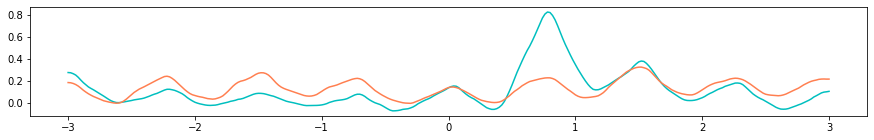

1080743752 0.6740240240240241 *


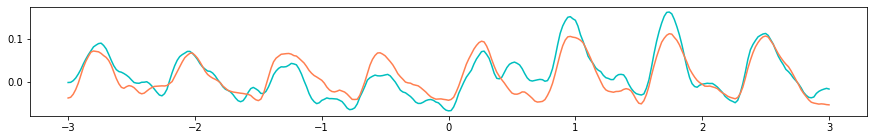

1080743754 0.6243243243243243 *


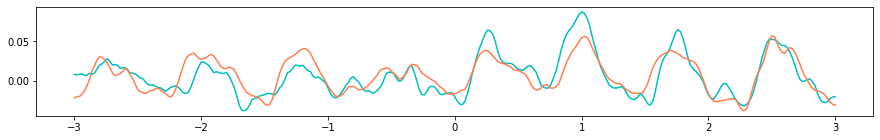

1080743763 0.6243243243243243 *


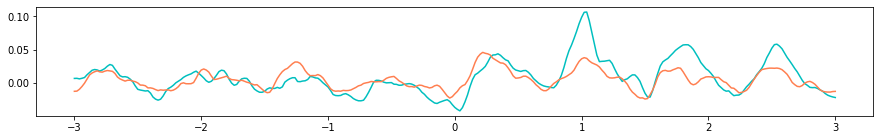

1080743765 0.6409909909909909 *


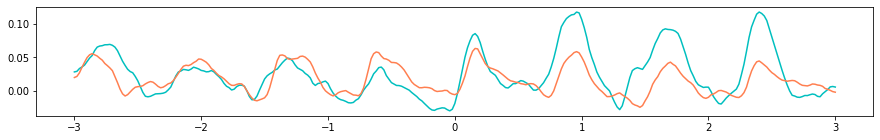

1080743775 0.6409909909909909 *


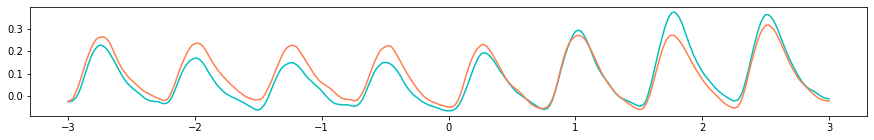

1080743785 0.6633633633633633 *


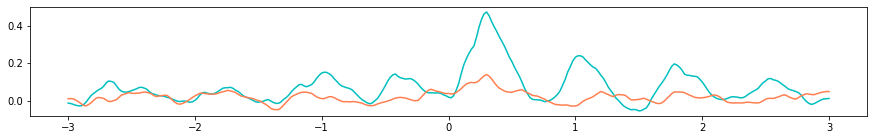

1080743794 0.6409909909909909 *


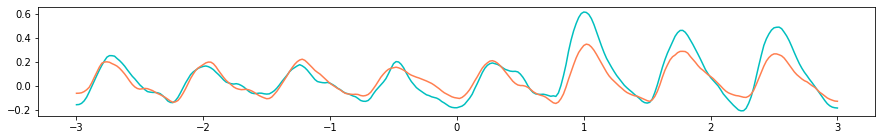

1080743799 0.6303303303303303 *


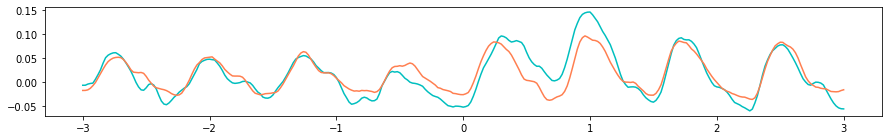

1080743817 0.7021021021021021 **


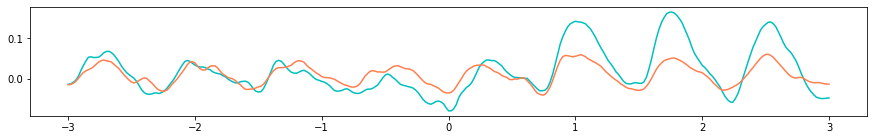

1080743831 0.6298798798798798 *


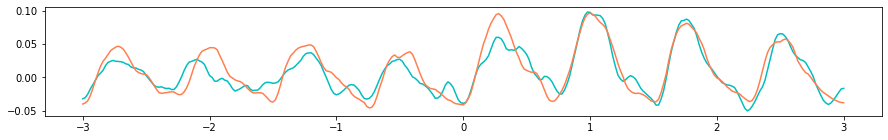

1080743847 0.6460960960960962 *


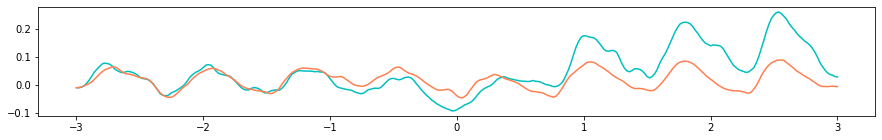

1080744295 0.6079579579579579 *


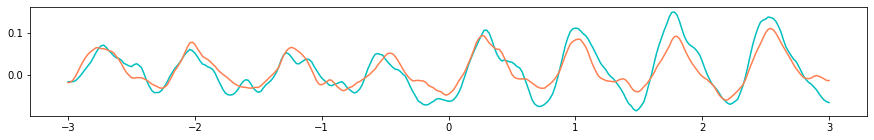

1080744315 0.6297297297297297 *


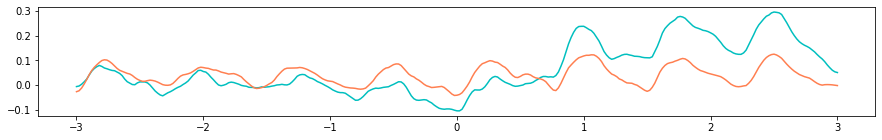

1080744321 0.6354354354354353 *


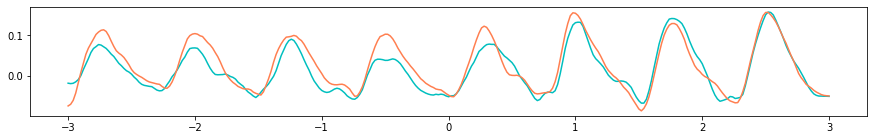

1080744326 0.6518018018018018 *


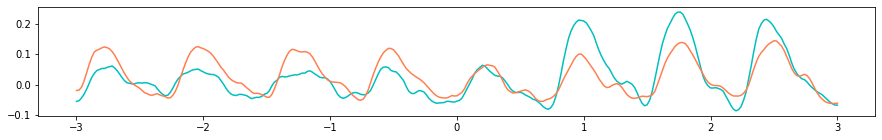

1080744337 0.6241741741741742 *


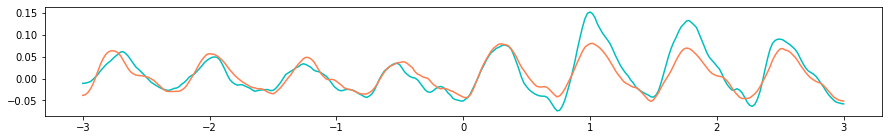

1080744341 0.6578078078078078 *


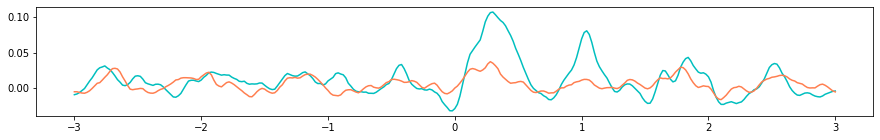

1080744344 0.6463963963963963 *


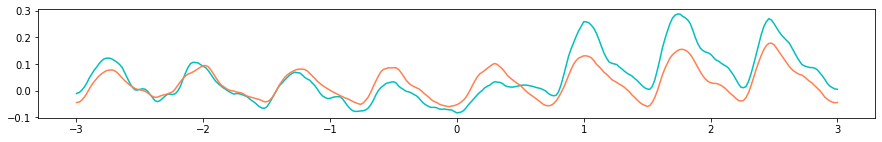

1080744349 0.6354354354354353 *


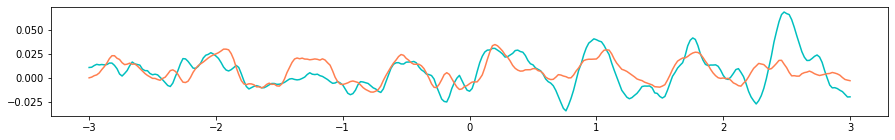

1080744354 0.6187687687687687 *


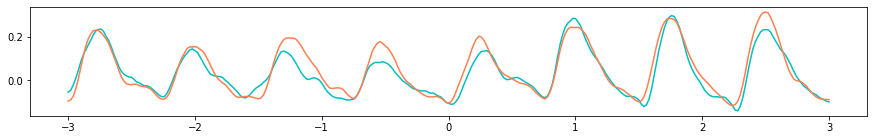

1080744373 0.6354354354354353 *


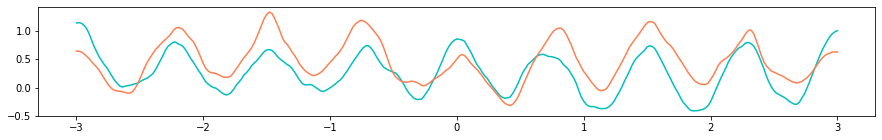

1080744391 0.6297297297297296 *


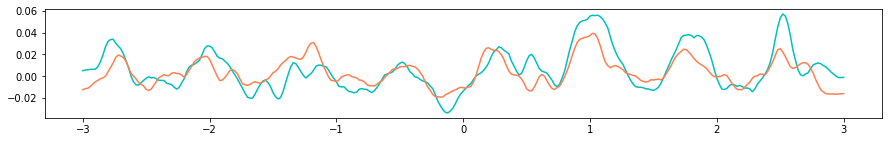

1080744401 0.640990990990991 *


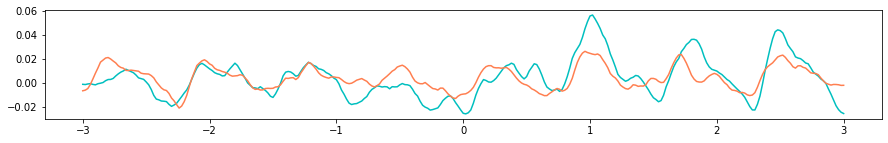

1080744985 0.6244744744744745 *


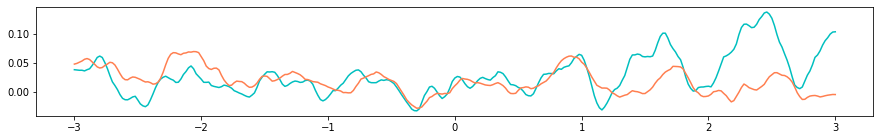

1080744993 0.6744744744744745 *


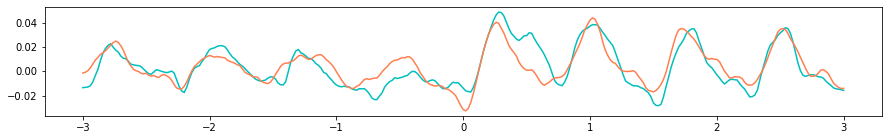

1080744997 0.6354354354354353 *


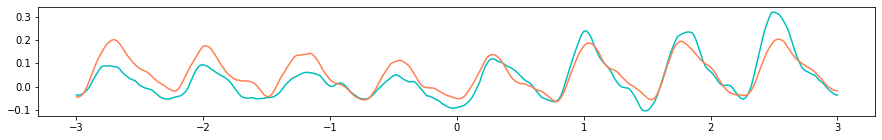

1080744999 0.6846846846846846 *


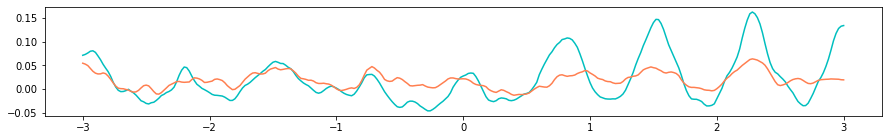

1080745001 0.6354354354354353 *


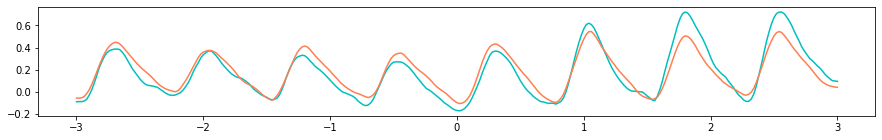

1080745003 0.6354354354354353 *


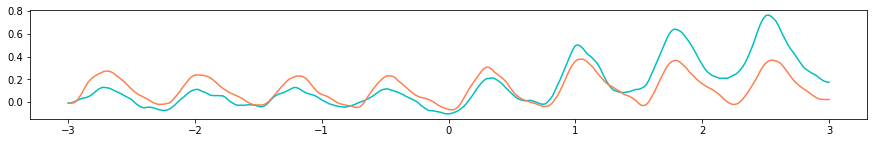

1080745009 0.6298798798798798 *


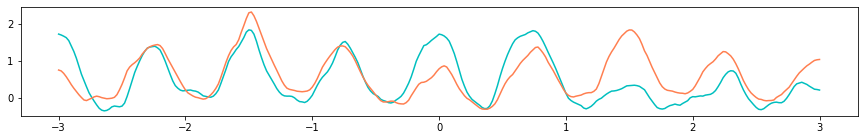

1080745012 0.6851351351351351 *


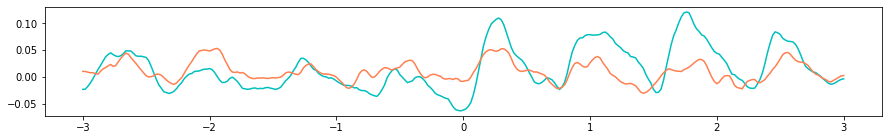

1080745021 0.662912912912913 *


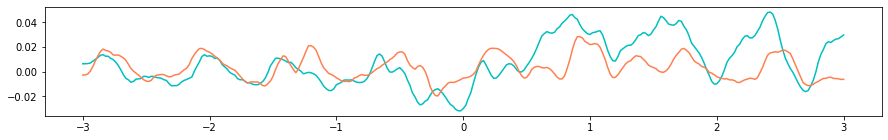

1080745024 0.6355855855855855 *


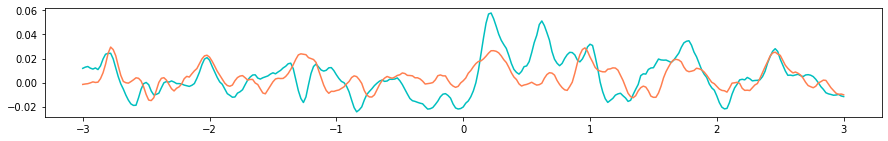

1080745027 0.6738738738738738 *


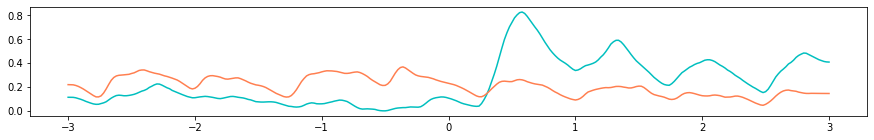

1080745030 0.6298798798798798 *


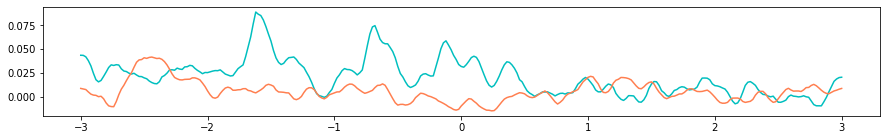

1080743698 0.6465465465465465 *


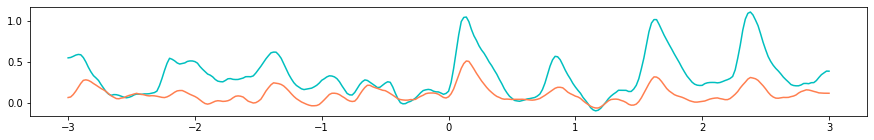

1080743701 0.6795795795795796 *


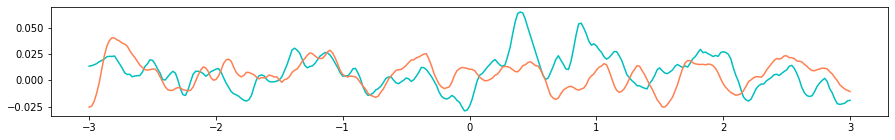

1080743706 0.6575075075075074 *


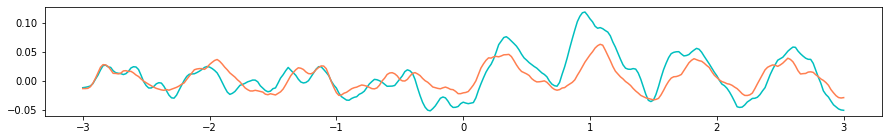

1080743708 0.6686186186186187 *


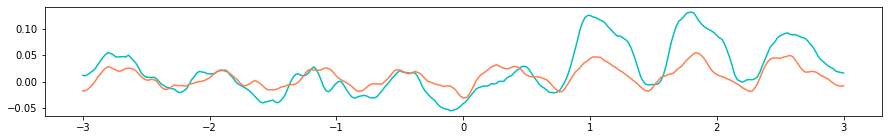

1080743712 0.6683183183183182 *


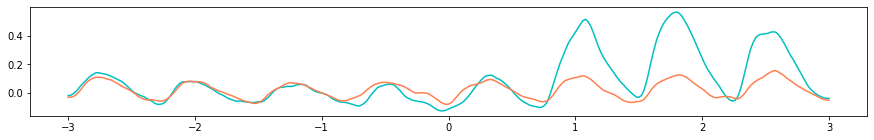

1080743737 0.6462462462462463 *


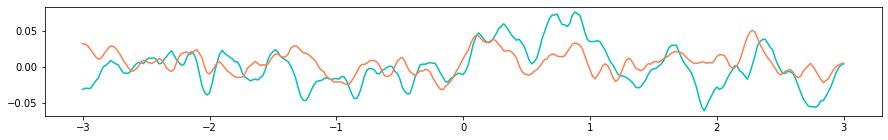

1080743741 0.634984984984985 *


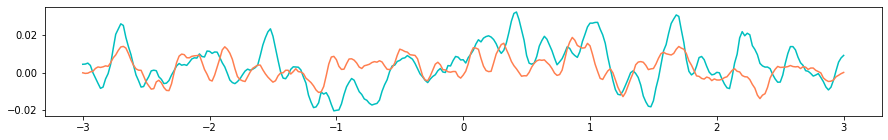

1080743762 0.7235735735735735 **


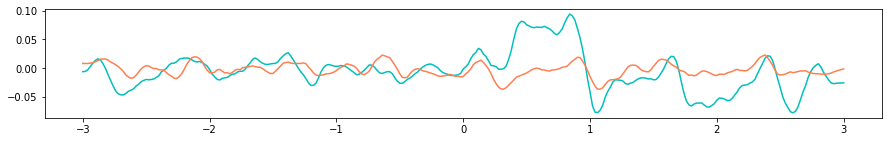

1080743783 0.6468468468468468 *


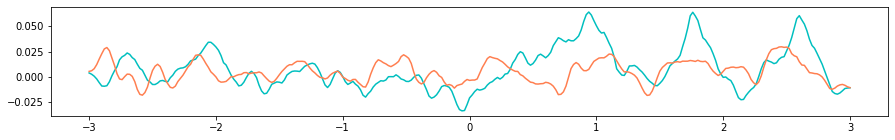

1080743802 0.6465465465465464 *


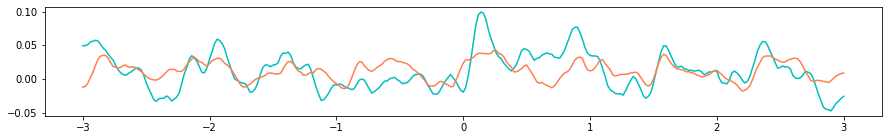

1080743829 0.63003003003003 *


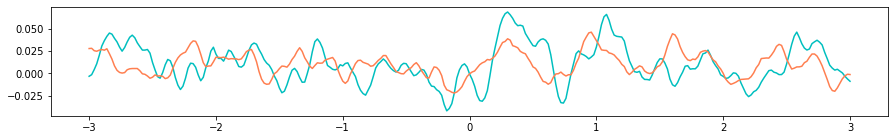

1080743834 0.6524024024024024 *


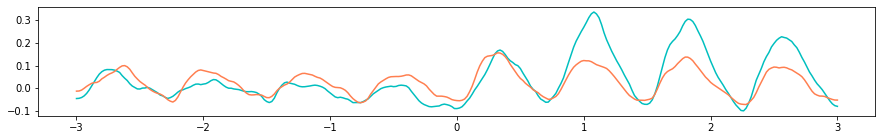

1080743841 0.6354354354354353 *


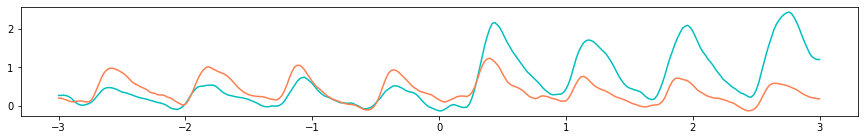

1080743855 0.6025525525525526 *


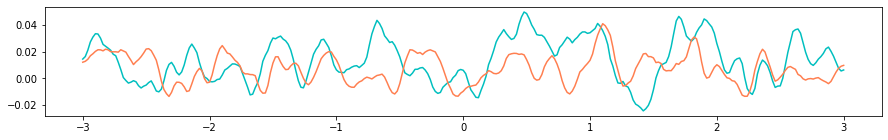

1080743862 0.6354354354354353 *


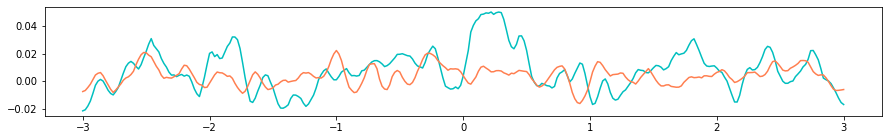

1080743868 0.6244744744744745 *


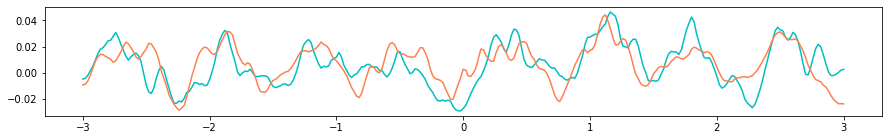

1080743873 0.6409909909909909 *


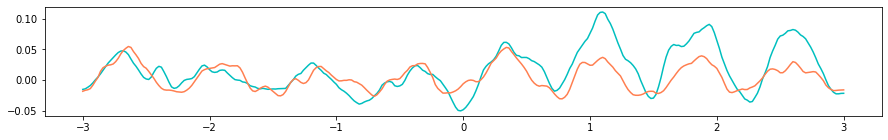

1080743886 0.6576576576576577 *


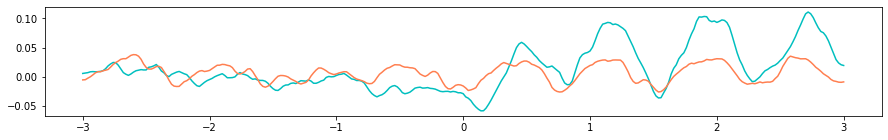

1080743904 0.7124624624624625 **


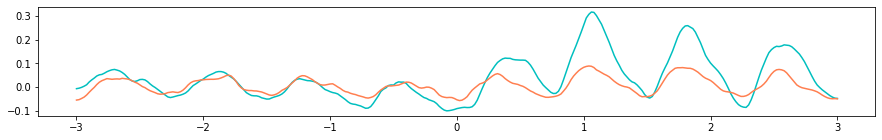

1080743912 0.7073573573573574 **


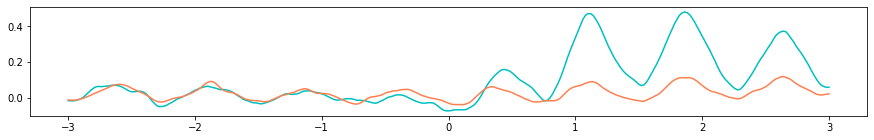

1080743916 0.6081081081081081 *


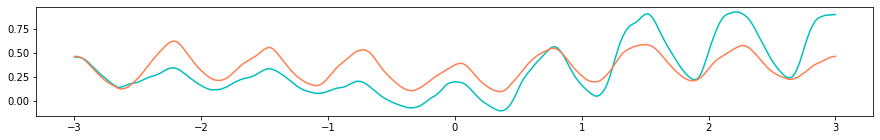

1080743932 0.596996996996997 


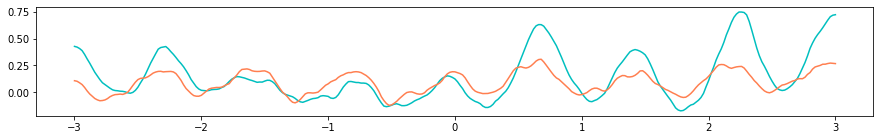

1080738970 0.6575075075075075 *


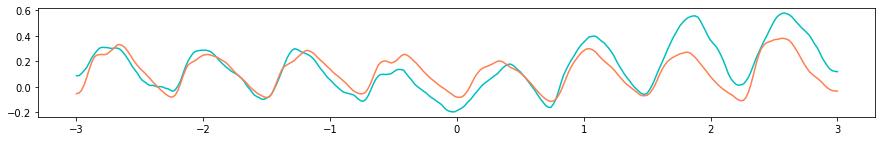

1080738971 0.6354354354354353 *


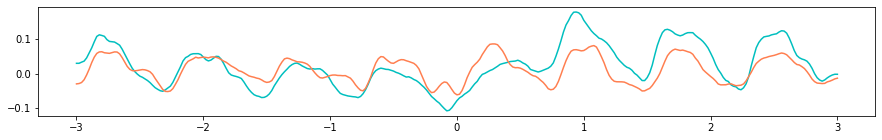

1080738974 0.6851351351351351 *


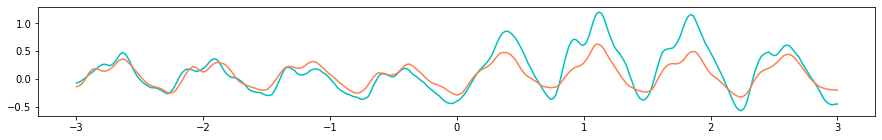

1080738976 0.6298798798798798 *


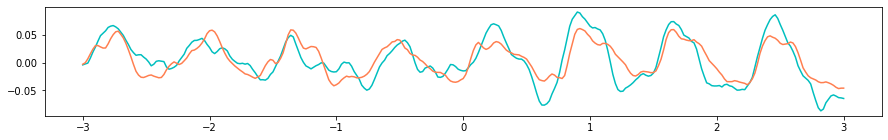

1080738985 0.756906906906907 **


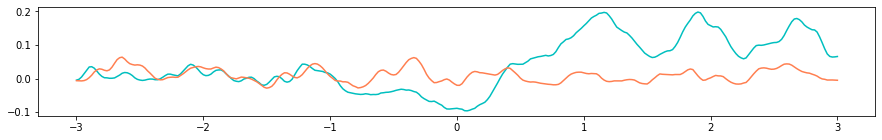

1080738999 0.7286786786786787 **


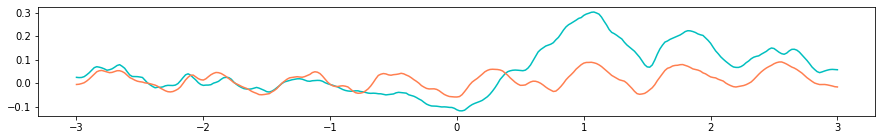

1080739002 0.5963963963963963 


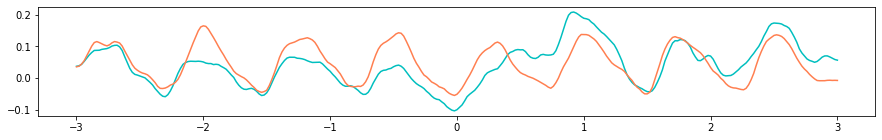

1080739004 0.6457957957957958 *


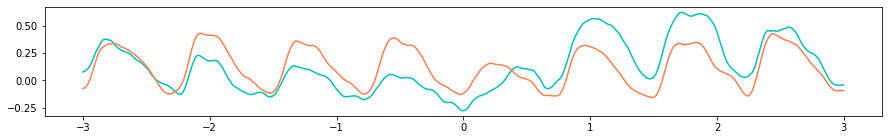

1080739007 0.6408408408408409 *


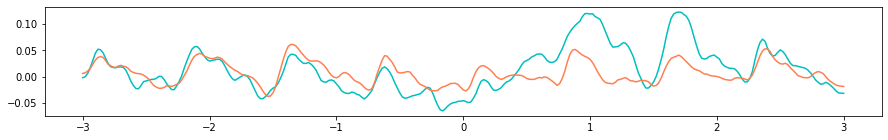

1080739009 0.6354354354354353 *


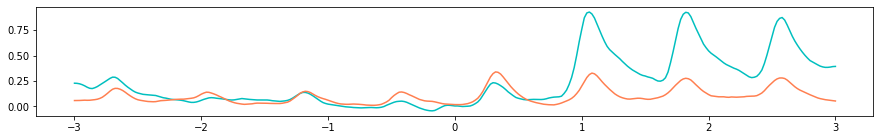

1080739015 0.6295795795795796 *


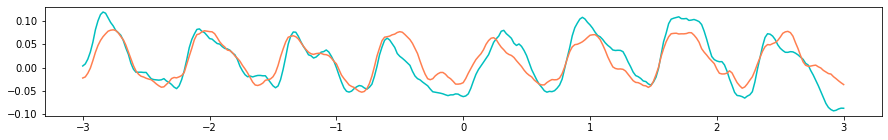

1080739019 0.6578078078078078 *


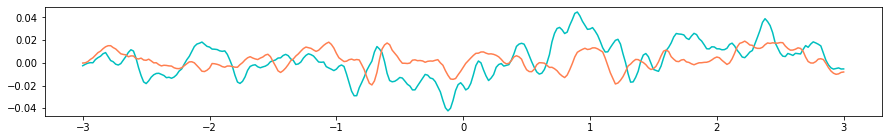

1080739033 0.6298798798798798 *


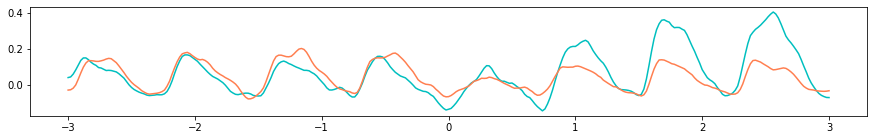

1080739049 0.6409909909909909 *


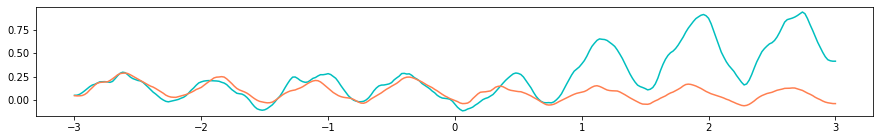

1080739616 0.6409909909909909 *


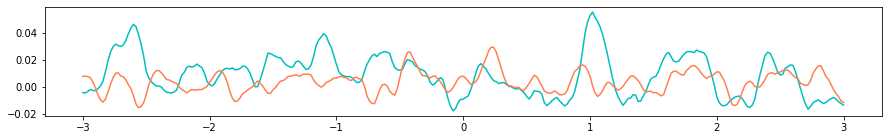

1080739641 0.6244744744744745 *


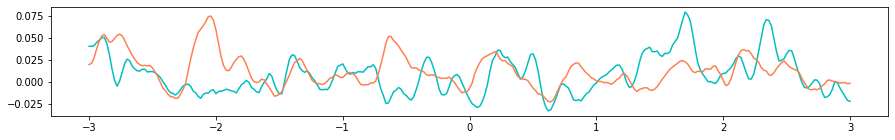

1080739660 0.6189189189189189 *


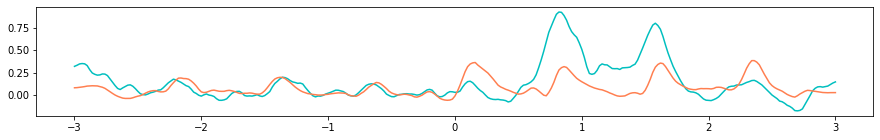

1080739673 0.6298798798798798 *


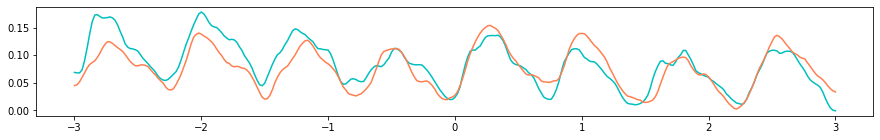

1080739680 0.6409909909909909 *


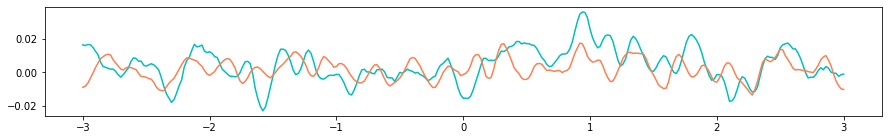

1080739702 0.645945945945946 *


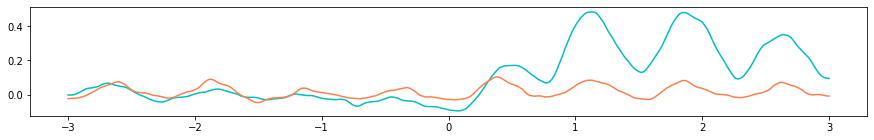

1080742677 0.7127627627627628 **


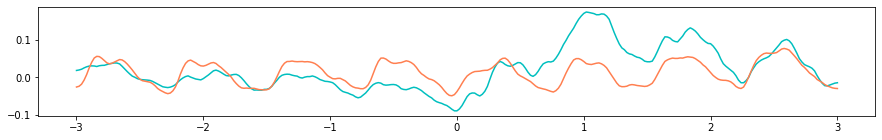

1080742681 0.6354354354354353 *


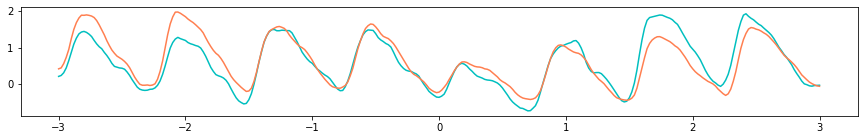

1080742683 0.662912912912913 *


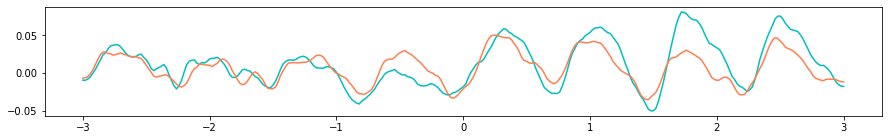

1080742684 0.5968468468468469 


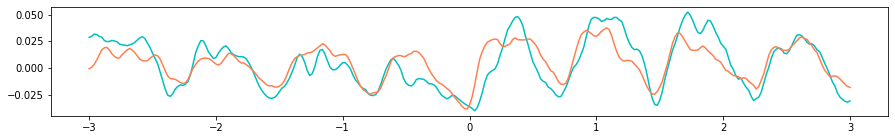

1080742685 0.6298798798798798 *


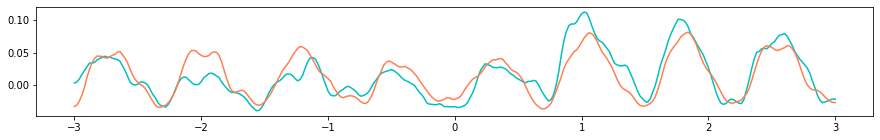

1080742688 0.602102102102102 *


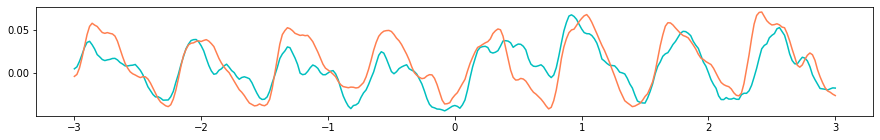

1080742694 0.640990990990991 *


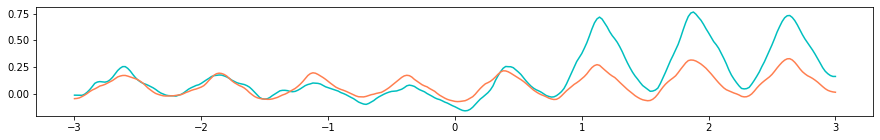

1080742698 0.6354354354354353 *


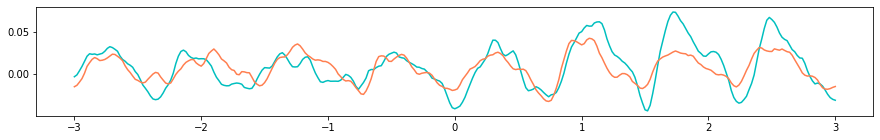

1080742701 0.6243243243243243 *


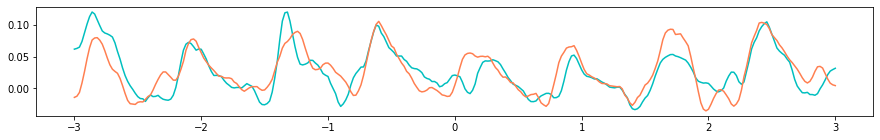

1080742704 0.6354354354354353 *


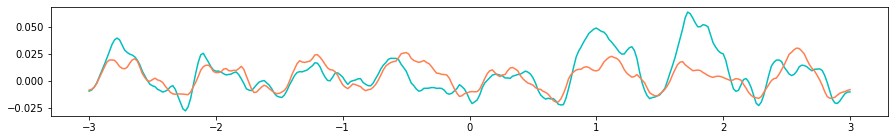

In [27]:
for cell_roi_id in cells_roi_ids:
  av = np.average(cells_lr_dictionary[cell_roi_id][3])
  if av > 0.7:
    stars = '**'
  elif av > 0.6:
    stars = '*'
  elif av < 0.5:
    stars = ':('
  else:
    stars = ''
  print(cell_roi_id, av, stars)
  plt.figure(figsize=(15,2))
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'hit')],
              color='c')
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'miss')],
              color='coral')
  plt.show()


## LR - k-fold cross validation

In [29]:
#list cells
#cells_roi_ids = my_cells.cell_roi_id.unique()
#find position of a respective columns
bfr = -1
aftr = 1
loc_minus = my_cells_pivot.columns.get_loc(bfr)
loc_plus = my_cells_pivot.columns.get_loc(aftr)
cells_lr_dictionary2 = {}
for cell_roi_id in cells_roi_ids:
  trial_result = my_cells_pivot.loc[cell_roi_id].hit
  timeseries = my_cells_pivot.loc[cell_roi_id].iloc[:,loc_minus:loc_plus+1]
  #log_reg = LogisticRegression(penalty='l2', max_iter=500)
  crsval = cross_val_score(LogisticRegression(penalty='l2', max_iter=500), timeseries, trial_result, cv=5)
  #print('Cell ID:', cell_id, "Number of recorded results:", len(trial_result), "Number of recorded timepoints:", timeseries.shape)
  cells_lr_dictionary2[cell_roi_id] = [trial_result, timeseries, crsval]

1080743723 [0.81081081 0.75       0.69444444 0.86111111 0.91666667]


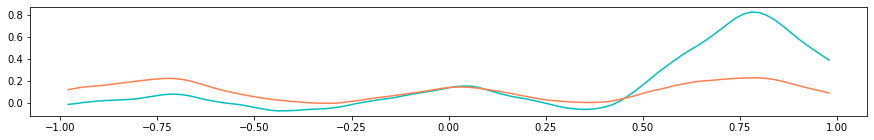

1080743752 [0.56756757 0.63888889 0.69444444 0.72222222 0.75      ]


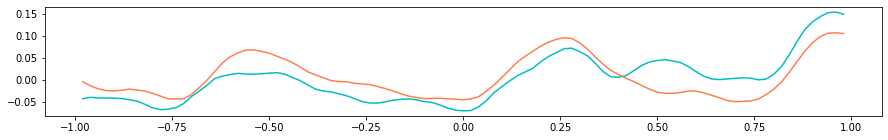

1080743754 [0.59459459 0.61111111 0.47222222 0.58333333 0.61111111]


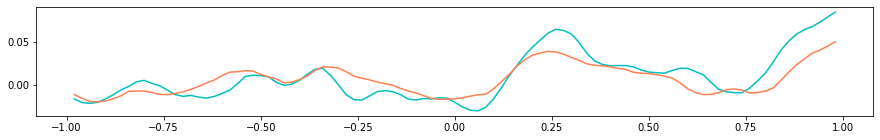

1080743763 [0.59459459 0.66666667 0.55555556 0.72222222 0.69444444]


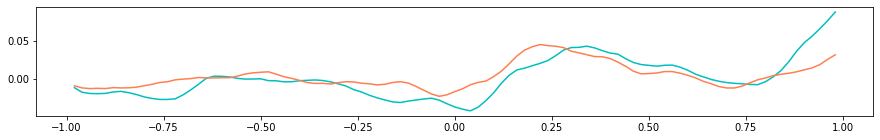

1080743765 [0.64864865 0.63888889 0.58333333 0.63888889 0.61111111]


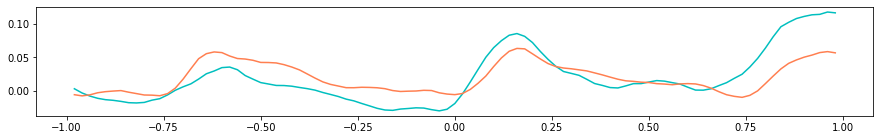

1080743775 [0.59459459 0.63888889 0.58333333 0.63888889 0.63888889]


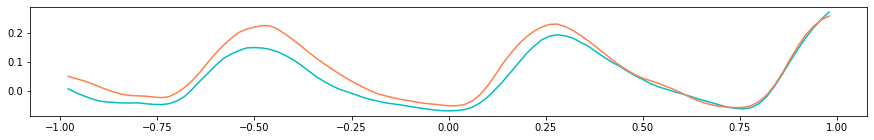

1080743785 [0.67567568 0.66666667 0.75       0.63888889 0.52777778]


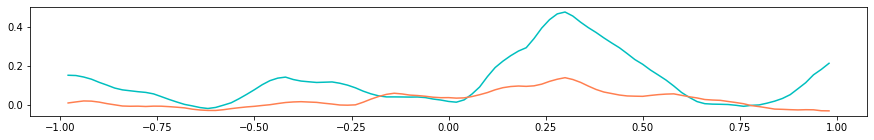

1080743794 [0.75675676 0.63888889 0.63888889 0.75       0.69444444]


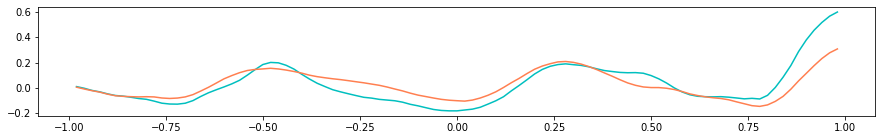

1080743799 [0.75675676 0.69444444 0.66666667 0.66666667 0.72222222]


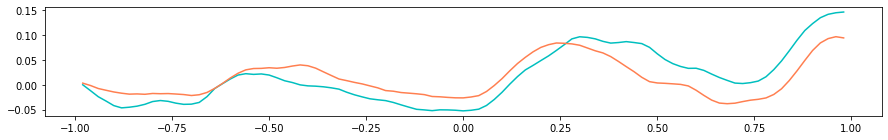

1080743817 [0.56756757 0.63888889 0.72222222 0.75       0.69444444]


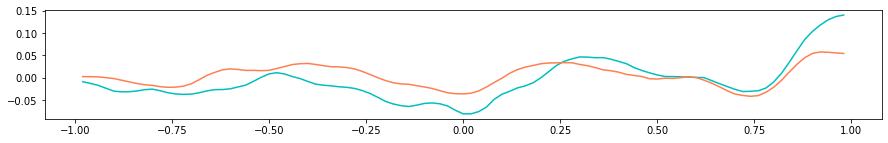

1080743831 [0.64864865 0.58333333 0.63888889 0.63888889 0.5       ]


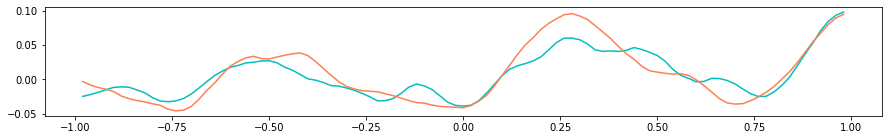

1080743847 [0.7027027  0.66666667 0.69444444 0.61111111 0.63888889]


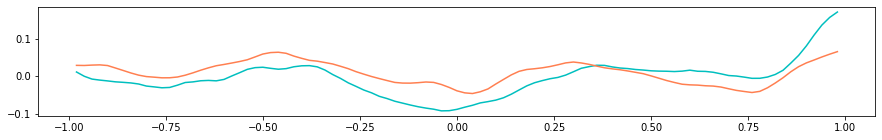

1080744295 [0.67567568 0.69444444 0.61111111 0.77777778 0.66666667]


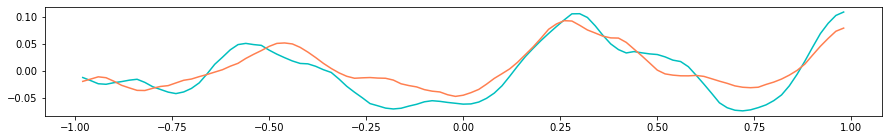

1080744315 [0.81081081 0.72222222 0.66666667 0.77777778 0.75      ]


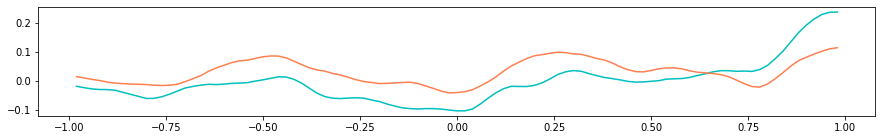

1080744321 [0.64864865 0.58333333 0.55555556 0.61111111 0.69444444]


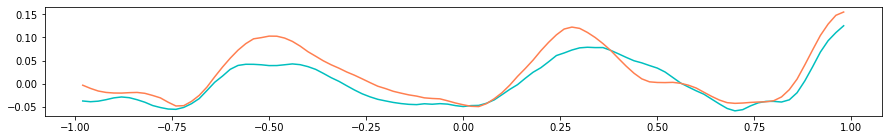

1080744326 [0.7027027  0.55555556 0.61111111 0.63888889 0.72222222]


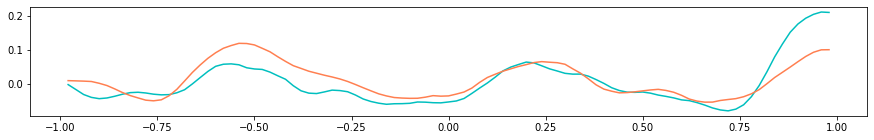

1080744337 [0.59459459 0.63888889 0.63888889 0.66666667 0.63888889]


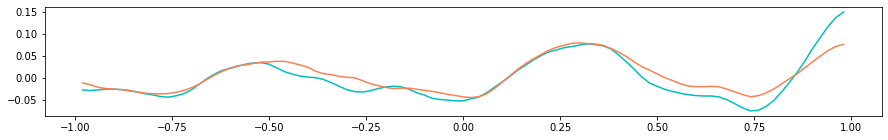

1080744341 [0.62162162 0.63888889 0.69444444 0.63888889 0.69444444]


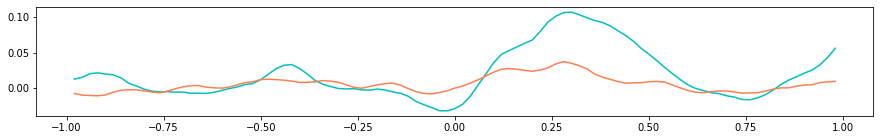

1080744344 [0.48648649 0.77777778 0.66666667 0.72222222 0.72222222]


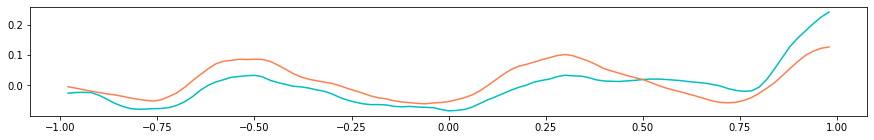

1080744349 [0.62162162 0.63888889 0.66666667 0.61111111 0.58333333]


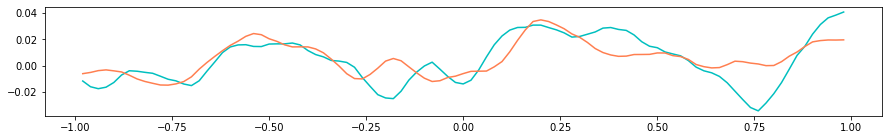

1080744354 [0.51351351 0.61111111 0.58333333 0.61111111 0.55555556]


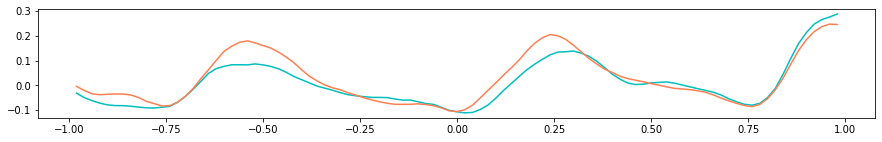

1080744373 [0.7027027  0.77777778 0.72222222 0.61111111 0.61111111]


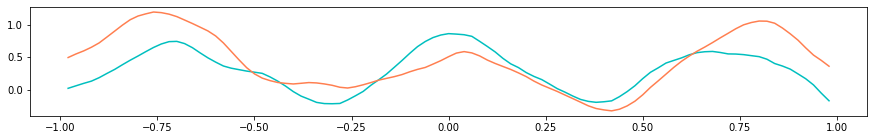

1080744391 [0.62162162 0.63888889 0.61111111 0.63888889 0.61111111]


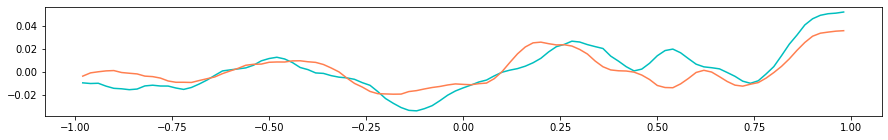

1080744401 [0.67567568 0.63888889 0.63888889 0.63888889 0.66666667]


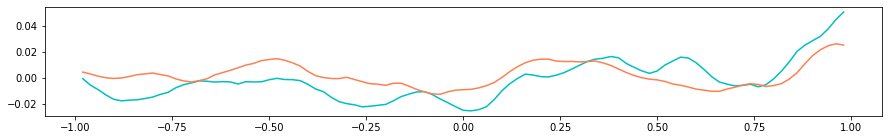

1080744985 [0.59459459 0.55555556 0.58333333 0.63888889 0.63888889]


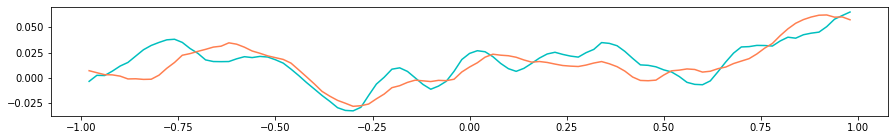

1080744993 [0.64864865 0.63888889 0.72222222 0.61111111 0.63888889]


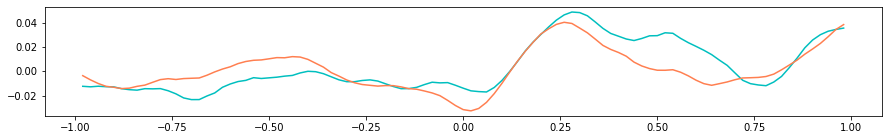

1080744997 [0.51351351 0.58333333 0.69444444 0.55555556 0.63888889]


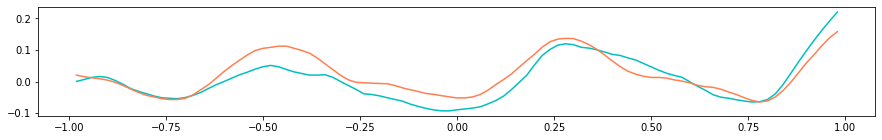

1080744999 [0.62162162 0.61111111 0.72222222 0.66666667 0.66666667]


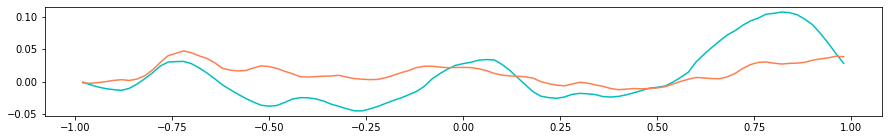

1080745001 [0.62162162 0.58333333 0.61111111 0.61111111 0.5       ]


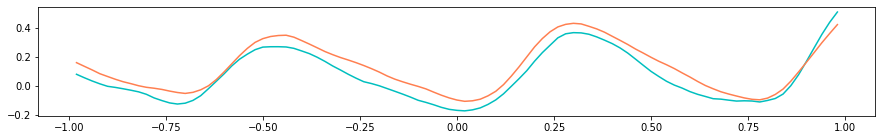

1080745003 [0.51351351 0.69444444 0.55555556 0.69444444 0.55555556]


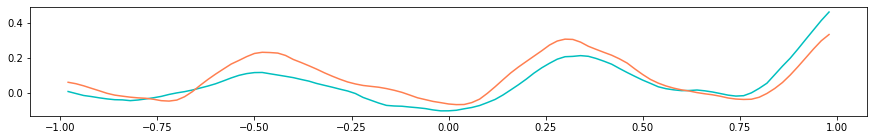

1080745009 [0.62162162 0.5        0.5        0.41666667 0.63888889]


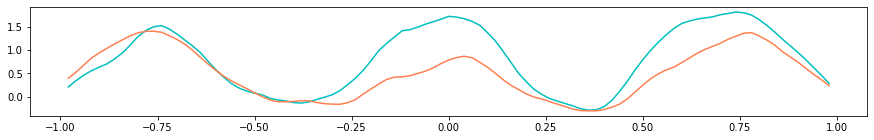

1080745012 [0.62162162 0.72222222 0.66666667 0.77777778 0.69444444]


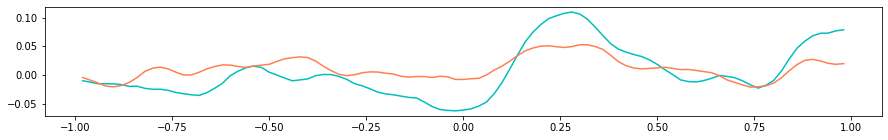

1080745021 [0.75675676 0.77777778 0.69444444 0.66666667 0.66666667]


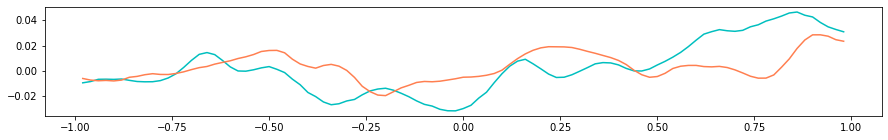

1080745024 [0.59459459 0.66666667 0.66666667 0.55555556 0.63888889]


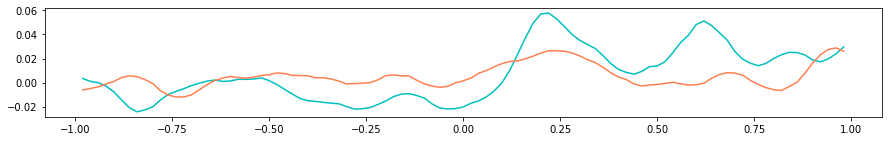

1080745027 [0.72972973 0.66666667 0.58333333 0.63888889 0.58333333]


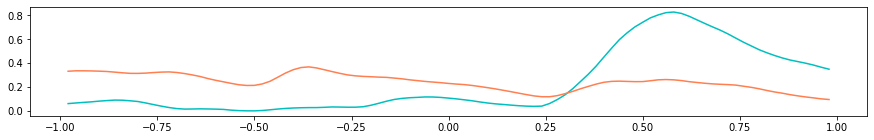

1080745030 [0.59459459 0.61111111 0.63888889 0.58333333 0.63888889]


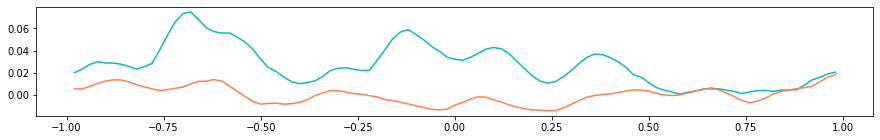

1080743698 [0.67567568 0.69444444 0.63888889 0.61111111 0.61111111]


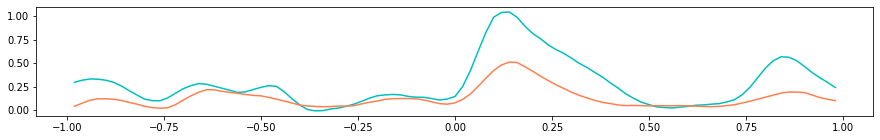

1080743701 [0.7027027  0.63888889 0.69444444 0.69444444 0.75      ]


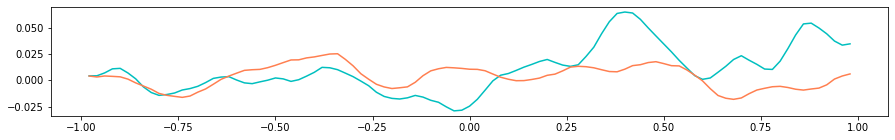

1080743706 [0.7027027  0.72222222 0.63888889 0.63888889 0.61111111]


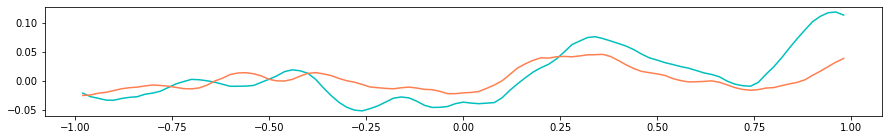

1080743708 [0.59459459 0.72222222 0.61111111 0.72222222 0.63888889]


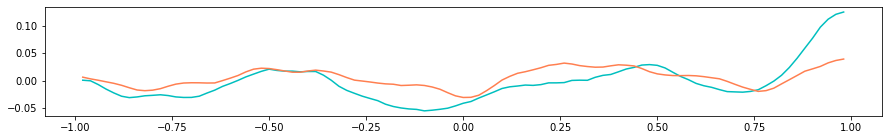

1080743712 [0.62162162 0.80555556 0.69444444 0.77777778 0.72222222]


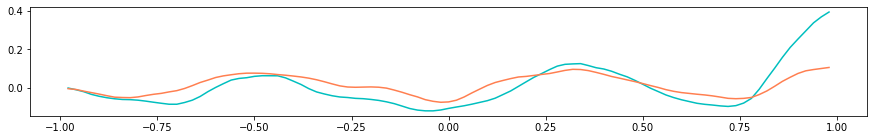

1080743737 [0.56756757 0.58333333 0.47222222 0.63888889 0.63888889]


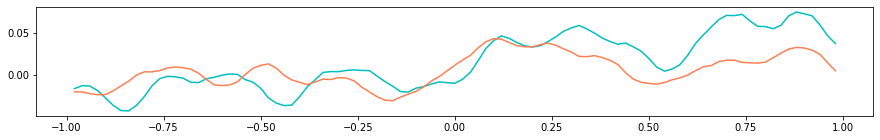

1080743741 [0.64864865 0.61111111 0.52777778 0.63888889 0.63888889]


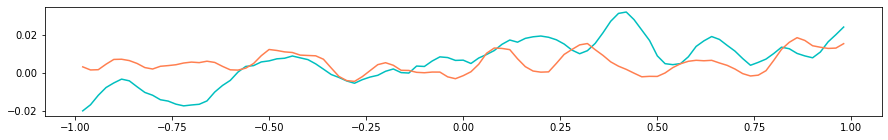

1080743762 [0.72972973 0.77777778 0.75       0.63888889 0.72222222]


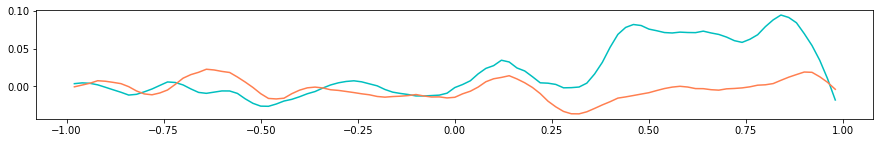

1080743783 [0.51351351 0.77777778 0.63888889 0.61111111 0.63888889]


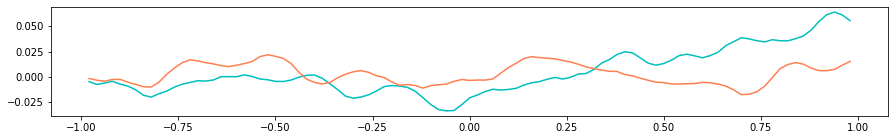

1080743802 [0.59459459 0.63888889 0.61111111 0.61111111 0.61111111]


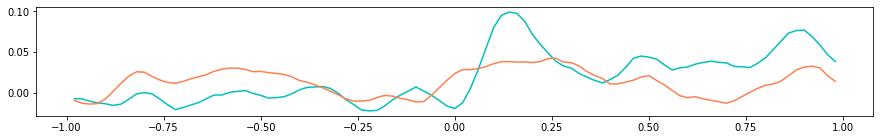

1080743829 [0.59459459 0.58333333 0.63888889 0.66666667 0.61111111]


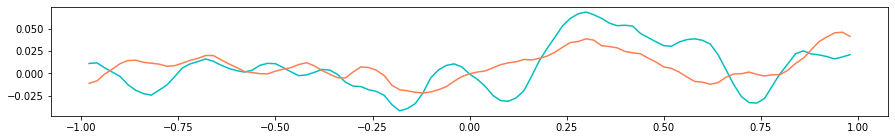

1080743834 [0.56756757 0.63888889 0.63888889 0.66666667 0.63888889]


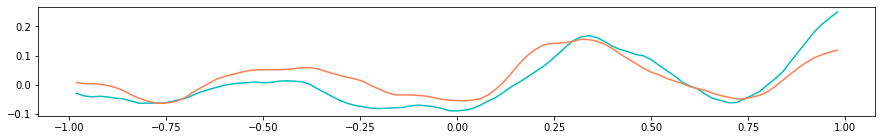

1080743841 [0.62162162 0.63888889 0.5        0.61111111 0.52777778]


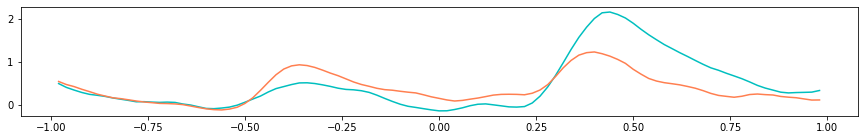

1080743855 [0.7027027  0.69444444 0.58333333 0.58333333 0.52777778]


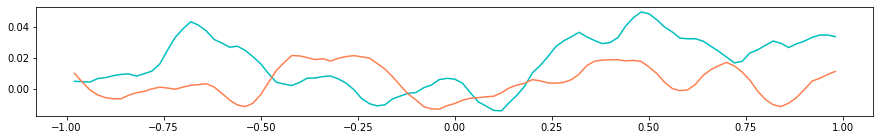

1080743862 [0.56756757 0.66666667 0.66666667 0.69444444 0.63888889]


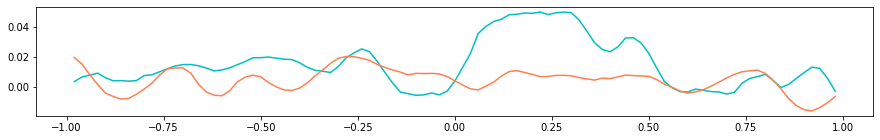

1080743868 [0.51351351 0.61111111 0.63888889 0.63888889 0.58333333]


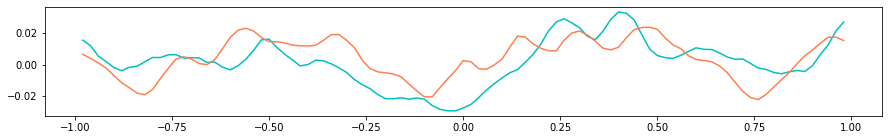

1080743873 [0.7027027  0.58333333 0.75       0.66666667 0.63888889]


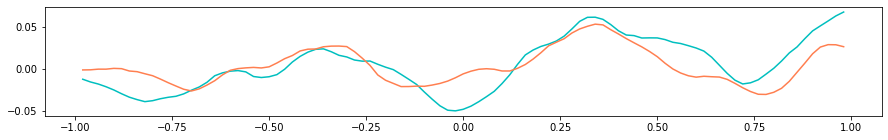

1080743886 [0.67567568 0.72222222 0.63888889 0.69444444 0.75      ]


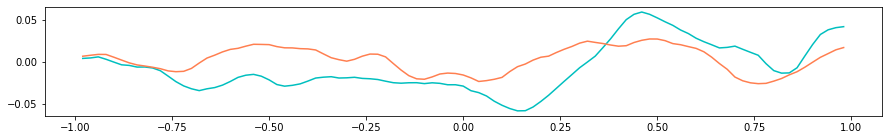

1080743904 [0.67567568 0.77777778 0.69444444 0.72222222 0.69444444]


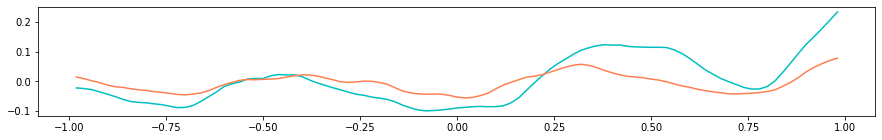

1080743912 [0.67567568 0.80555556 0.72222222 0.69444444 0.75      ]


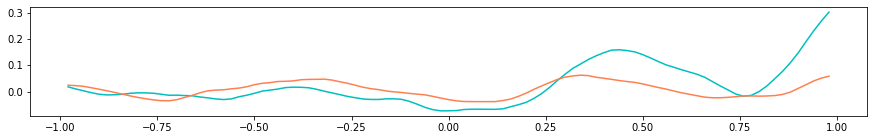

1080743916 [0.7027027  0.55555556 0.72222222 0.66666667 0.66666667]


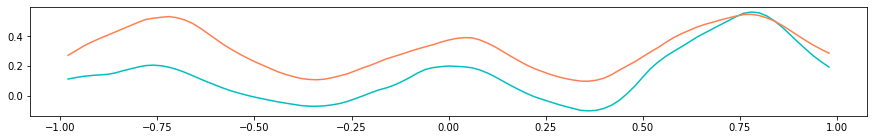

1080743932 [0.72972973 0.61111111 0.63888889 0.61111111 0.58333333]


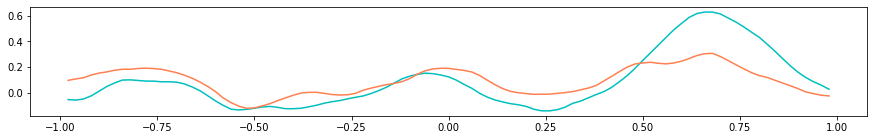

1080738970 [0.64864865 0.66666667 0.66666667 0.61111111 0.61111111]


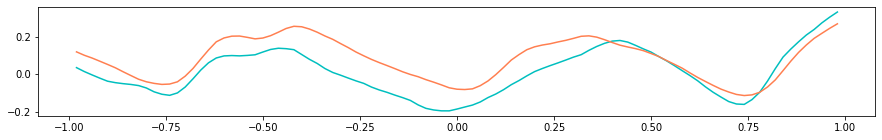

1080738971 [0.75675676 0.72222222 0.66666667 0.86111111 0.66666667]


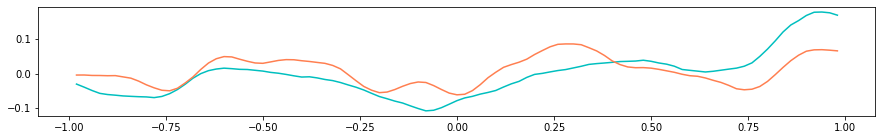

1080738974 [0.64864865 0.72222222 0.63888889 0.61111111 0.5       ]


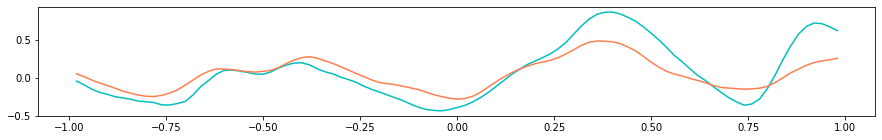

1080738976 [0.67567568 0.66666667 0.63888889 0.61111111 0.66666667]


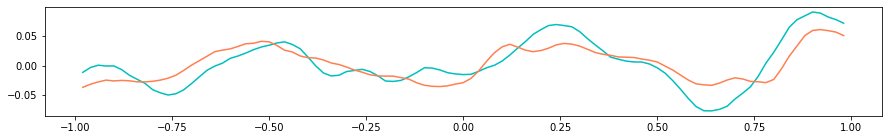

1080738985 [0.86486486 0.86111111 0.83333333 0.77777778 0.75      ]


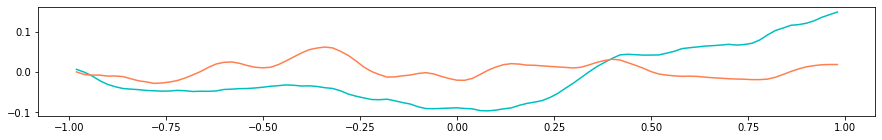

1080738999 [0.97297297 0.77777778 0.86111111 0.88888889 0.86111111]


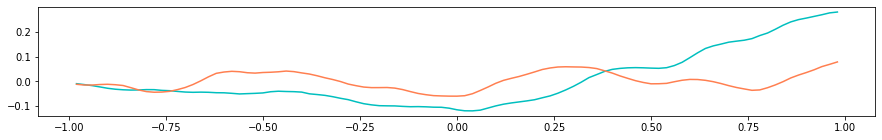

1080739002 [0.64864865 0.72222222 0.69444444 0.77777778 0.80555556]


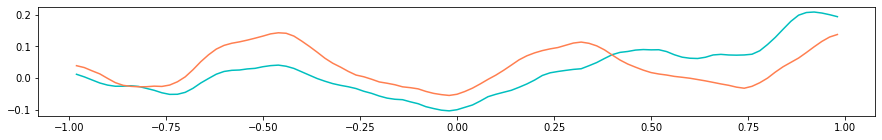

1080739004 [0.81081081 0.69444444 0.75       0.61111111 0.66666667]


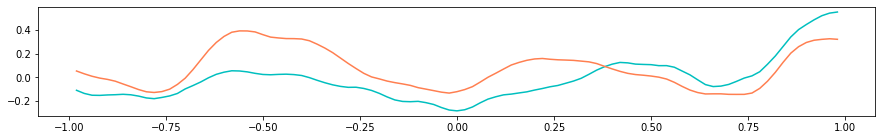

1080739007 [0.72972973 0.80555556 0.52777778 0.69444444 0.61111111]


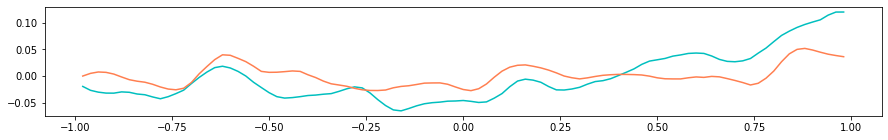

1080739009 [0.81081081 0.83333333 0.80555556 0.69444444 0.63888889]


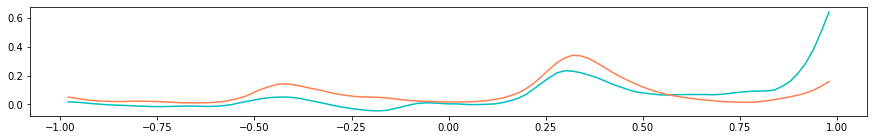

1080739015 [0.59459459 0.66666667 0.61111111 0.58333333 0.61111111]


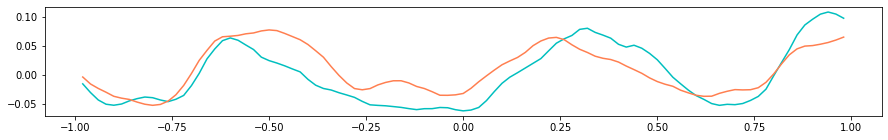

1080739019 [0.59459459 0.72222222 0.72222222 0.72222222 0.72222222]


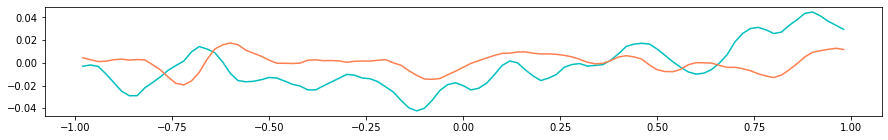

1080739033 [0.59459459 0.77777778 0.63888889 0.66666667 0.63888889]


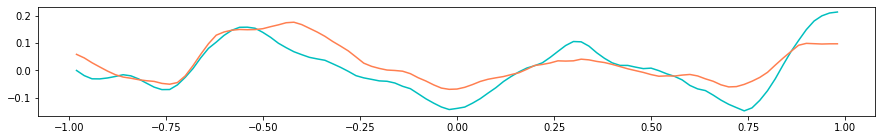

1080739049 [0.64864865 0.66666667 0.63888889 0.61111111 0.63888889]


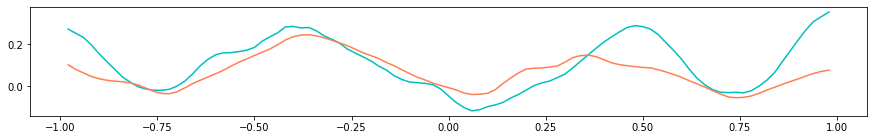

1080739616 [0.64864865 0.55555556 0.61111111 0.61111111 0.69444444]


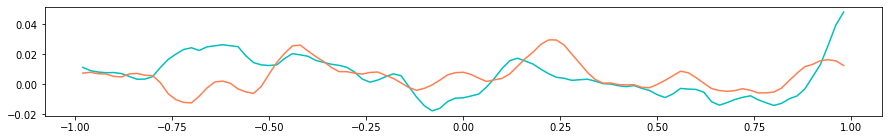

1080739641 [0.56756757 0.72222222 0.63888889 0.69444444 0.63888889]


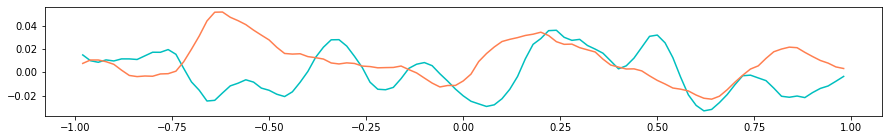

1080739660 [0.72972973 0.61111111 0.69444444 0.69444444 0.72222222]


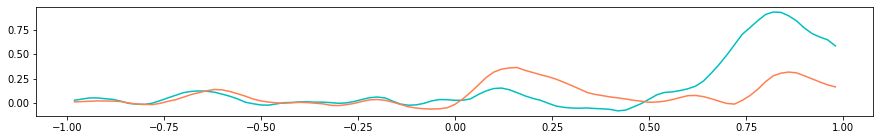

1080739673 [0.62162162 0.58333333 0.58333333 0.55555556 0.63888889]


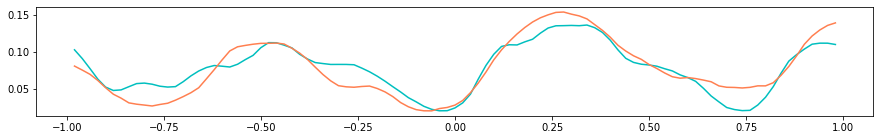

1080739680 [0.62162162 0.63888889 0.58333333 0.63888889 0.63888889]


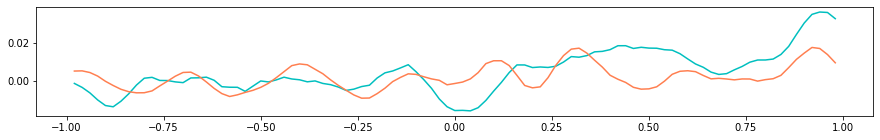

1080739702 [0.78378378 0.80555556 0.72222222 0.72222222 0.72222222]


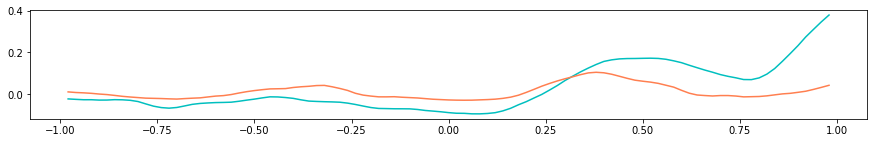

1080742677 [0.72972973 0.80555556 0.80555556 0.75       0.83333333]


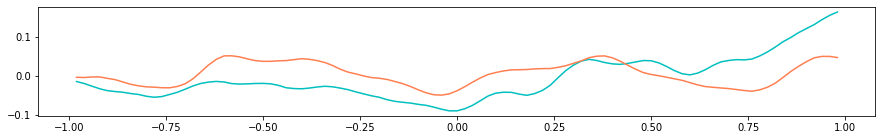

1080742681 [0.48648649 0.55555556 0.5        0.61111111 0.66666667]


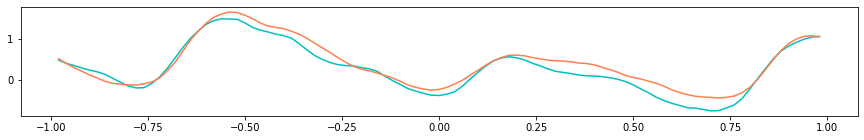

1080742683 [0.7027027  0.61111111 0.58333333 0.63888889 0.66666667]


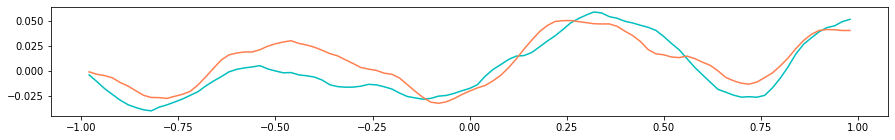

1080742684 [0.67567568 0.63888889 0.63888889 0.63888889 0.61111111]


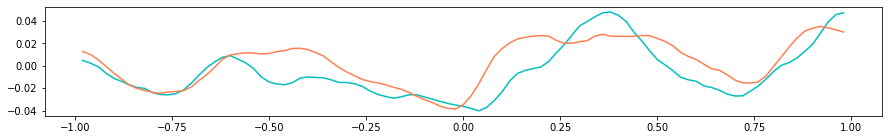

1080742685 [0.62162162 0.66666667 0.61111111 0.61111111 0.55555556]


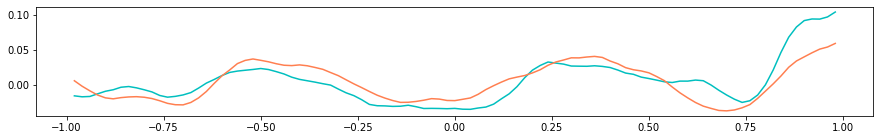

1080742688 [0.7027027  0.61111111 0.63888889 0.55555556 0.63888889]


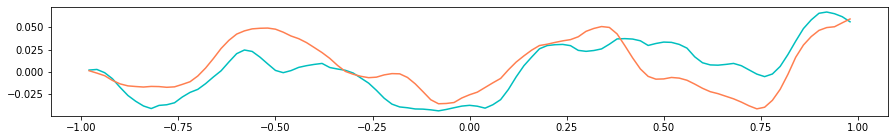

1080742694 [0.59459459 0.77777778 0.63888889 0.72222222 0.61111111]


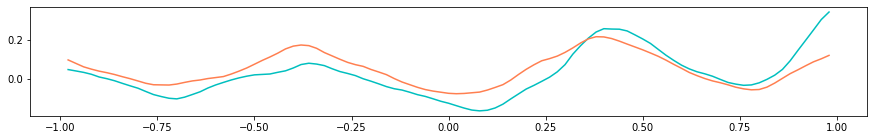

1080742698 [0.56756757 0.55555556 0.61111111 0.5        0.66666667]


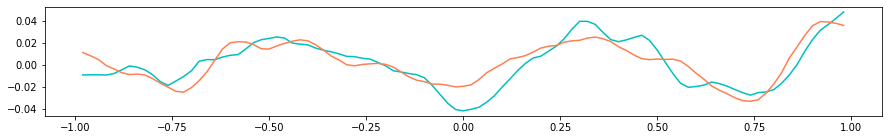

1080742701 [0.64864865 0.63888889 0.66666667 0.5        0.58333333]


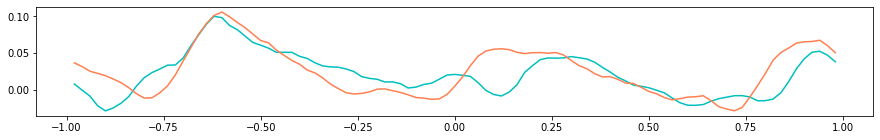

1080742704 [0.7027027  0.69444444 0.58333333 0.63888889 0.63888889]


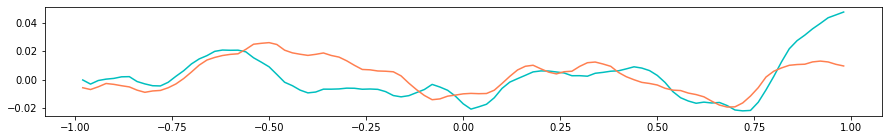

In [31]:
for cell_roi_id in cells_roi_ids:
  av = cells_lr_dictionary2[cell_roi_id][2]
  print(cell_roi_id, av)
  plt.figure(figsize=(15,2))
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'hit') & (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='c')
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'miss')& (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='coral')
  plt.show()

## All data & k-fold socres, descending

In [33]:
#list cells
#cells_roi_ids = my_cells.cell_roi_id.unique()
#find position of a respective columns
bfr = -1
aftr = 1
loc_minus = my_cells_pivot.columns.get_loc(bfr)
loc_plus = my_cells_pivot.columns.get_loc(aftr)
cells_lr_dictionary3 = {}
for cell_roi_id in cells_roi_ids:
  trial_result = my_cells_pivot.loc[cell_roi_id].hit
  timeseries = my_cells_pivot.loc[cell_roi_id].iloc[:,loc_minus:loc_plus+1]
  log_reg = LogisticRegression(penalty='l2', max_iter=500).fit(timeseries, trial_result)
  score_single = np.average(trial_result == log_reg.predict(timeseries))
  mean_score_cv = np.average(cross_val_score(LogisticRegression(penalty='l2', max_iter=500), timeseries, trial_result, cv=5))
  #print('Cell ID:', cell_id, "Number of recorded results:", len(trial_result), "Number of recorded timepoints:", timeseries.shape)
  cells_lr_dictionary3[cell_roi_id] = [trial_result, timeseries, log_reg, score_single, mean_score_cv]

In [34]:
#get scores and sort according to average
models_df = pd.DataFrame.from_dict(cells_lr_dictionary3, 
                                   orient = 'index', 
                                   columns = ['trial_result', 'timeseries', 'log_reg', 'score_single', 'mean_score_cv'])
models_df = models_df.sort_values('mean_score_cv', ascending=False)

cell_roi_id: 1080738999 All data score 0.9005524861878453 5-fold av. score 0.8723723723723724


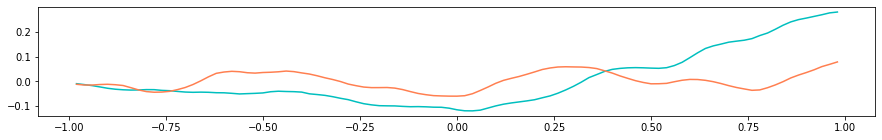

cell_roi_id: 1080738985 All data score 0.856353591160221 5-fold av. score 0.8174174174174175


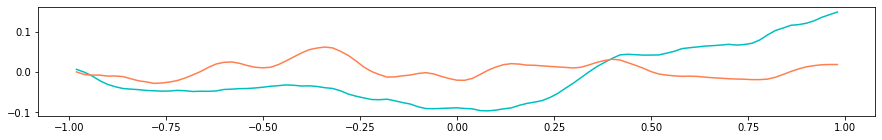

cell_roi_id: 1080743723 All data score 0.8397790055248618 5-fold av. score 0.8066066066066065


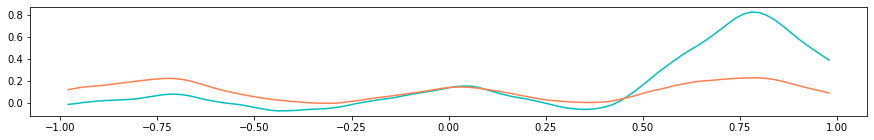

cell_roi_id: 1080742677 All data score 0.8232044198895028 5-fold av. score 0.7848348348348348


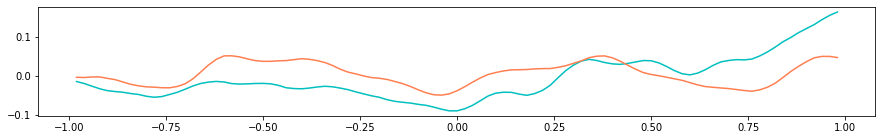

cell_roi_id: 1080739009 All data score 0.7679558011049724 5-fold av. score 0.7566066066066066


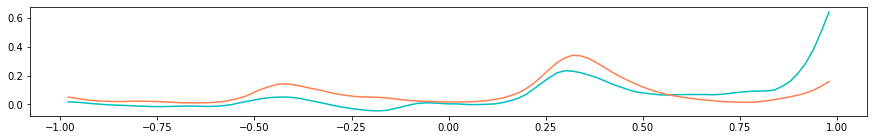

cell_roi_id: 1080739702 All data score 0.7955801104972375 5-fold av. score 0.7512012012012013


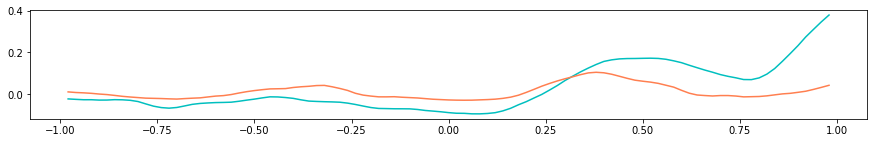

cell_roi_id: 1080744315 All data score 0.7845303867403315 5-fold av. score 0.7454954954954955


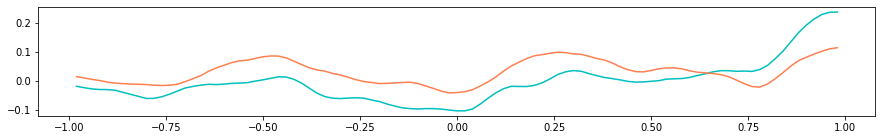

cell_roi_id: 1080738971 All data score 0.7734806629834254 5-fold av. score 0.7346846846846846


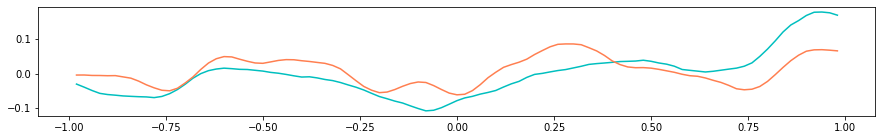

cell_roi_id: 1080739002 All data score 0.8011049723756906 5-fold av. score 0.7297297297297296


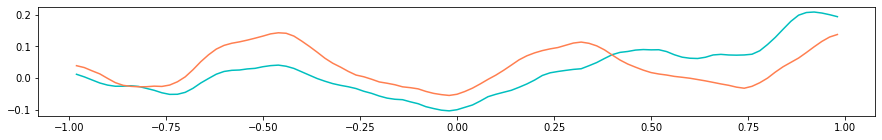

cell_roi_id: 1080743912 All data score 0.7734806629834254 5-fold av. score 0.7295795795795795


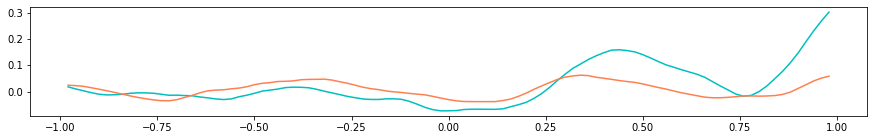

cell_roi_id: 1080743712 All data score 0.7569060773480663 5-fold av. score 0.7243243243243244


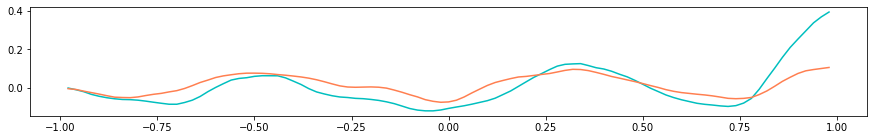

cell_roi_id: 1080743762 All data score 0.7845303867403315 5-fold av. score 0.7237237237237237


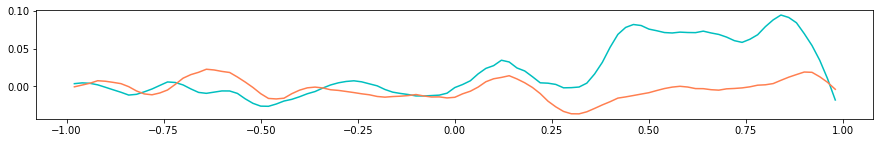

cell_roi_id: 1080743904 All data score 0.7569060773480663 5-fold av. score 0.7129129129129129


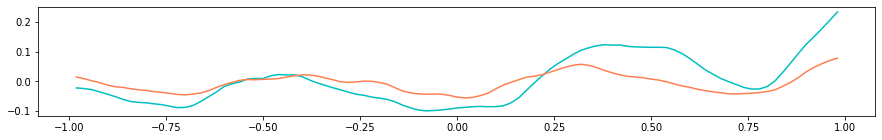

cell_roi_id: 1080745021 All data score 0.7458563535911602 5-fold av. score 0.7124624624624625


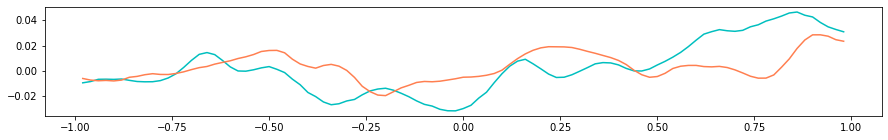

cell_roi_id: 1080739004 All data score 0.7900552486187845 5-fold av. score 0.7066066066066066


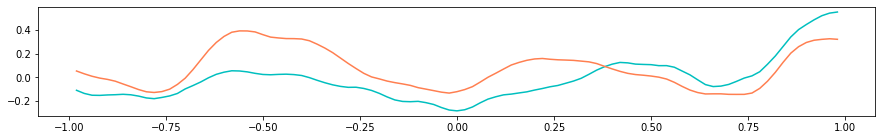

cell_roi_id: 1080743799 All data score 0.7513812154696132 5-fold av. score 0.7013513513513513


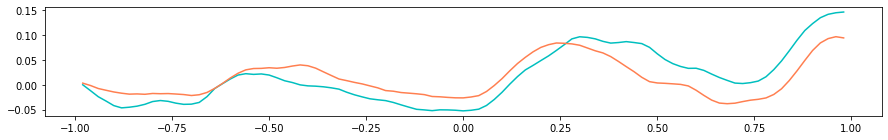

cell_roi_id: 1080739019 All data score 0.7292817679558011 5-fold av. score 0.6966966966966968


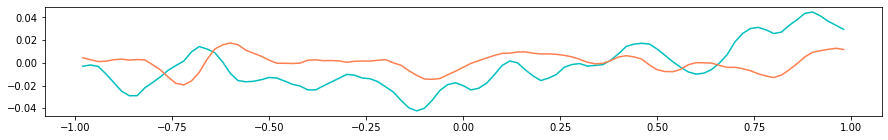

cell_roi_id: 1080745012 All data score 0.7348066298342542 5-fold av. score 0.6965465465465466


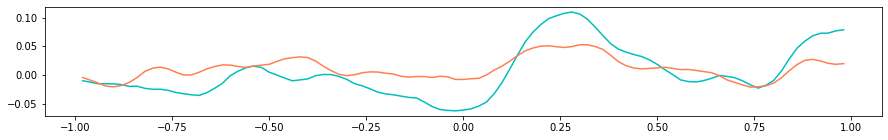

cell_roi_id: 1080743886 All data score 0.7292817679558011 5-fold av. score 0.6962462462462462


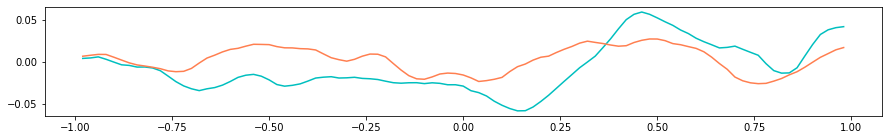

cell_roi_id: 1080743701 All data score 0.7569060773480663 5-fold av. score 0.696096096096096


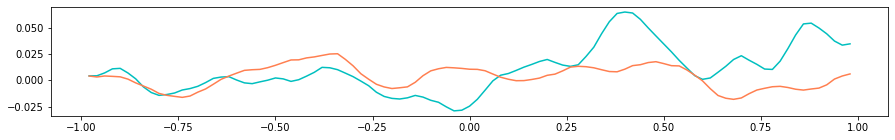

cell_roi_id: 1080743794 All data score 0.8011049723756906 5-fold av. score 0.6957957957957959


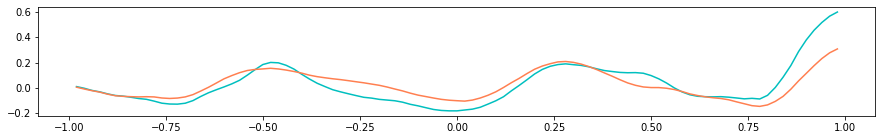

cell_roi_id: 1080739660 All data score 0.7900552486187845 5-fold av. score 0.6903903903903904


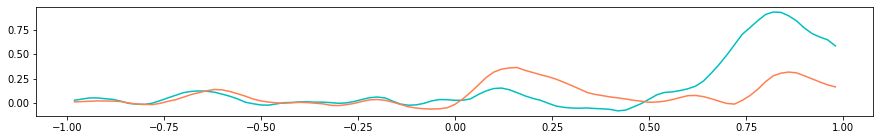

cell_roi_id: 1080744295 All data score 0.7458563535911602 5-fold av. score 0.6851351351351351


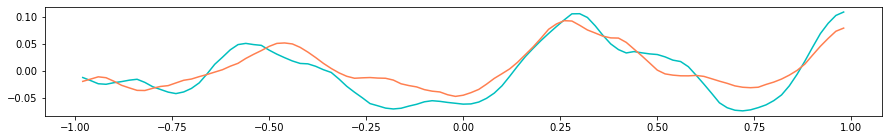

cell_roi_id: 1080744373 All data score 0.8176795580110497 5-fold av. score 0.684984984984985


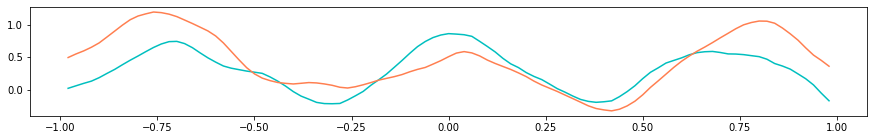

cell_roi_id: 1080744344 All data score 0.7458563535911602 5-fold av. score 0.6750750750750751


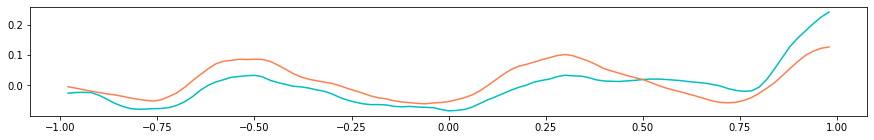

cell_roi_id: 1080743752 All data score 0.7458563535911602 5-fold av. score 0.6746246246246246


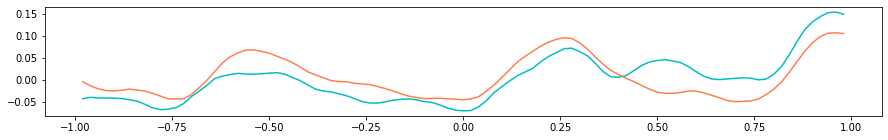

cell_roi_id: 1080743817 All data score 0.7679558011049724 5-fold av. score 0.6746246246246246


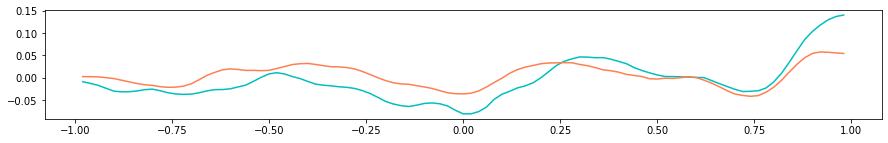

cell_roi_id: 1080739007 All data score 0.7237569060773481 5-fold av. score 0.6737237237237237


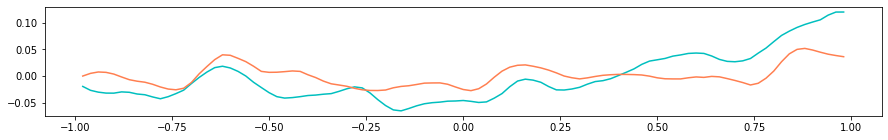

cell_roi_id: 1080742694 All data score 0.7513812154696132 5-fold av. score 0.668918918918919


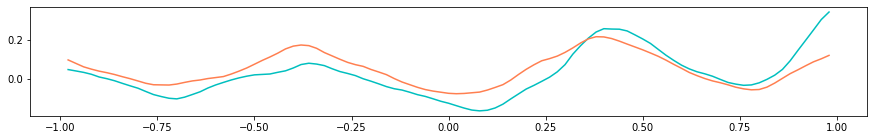

cell_roi_id: 1080743873 All data score 0.7292817679558011 5-fold av. score 0.6683183183183183


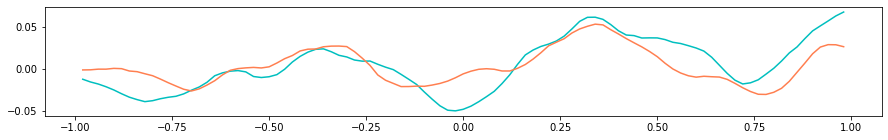

cell_roi_id: 1080739033 All data score 0.7403314917127072 5-fold av. score 0.6633633633633633


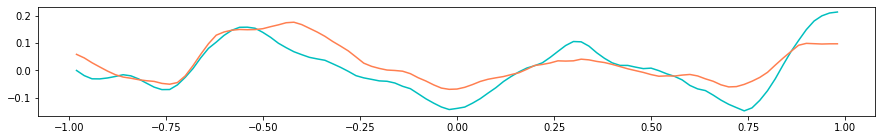

cell_roi_id: 1080743706 All data score 0.7071823204419889 5-fold av. score 0.6627627627627628


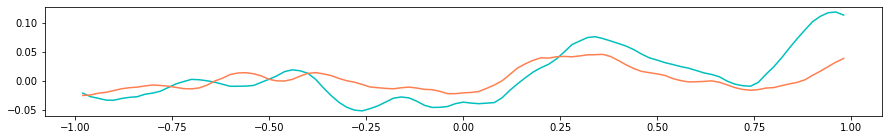

cell_roi_id: 1080743847 All data score 0.7348066298342542 5-fold av. score 0.6627627627627628


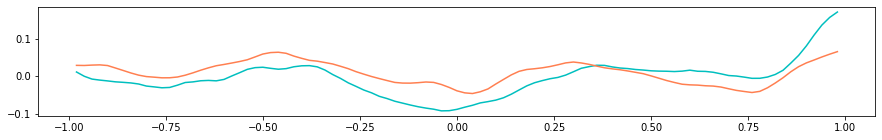

cell_roi_id: 1080743916 All data score 0.7292817679558011 5-fold av. score 0.6627627627627628


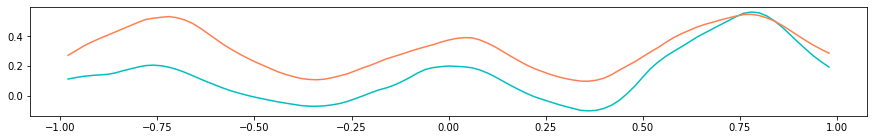

cell_roi_id: 1080743708 All data score 0.7292817679558011 5-fold av. score 0.6578078078078078


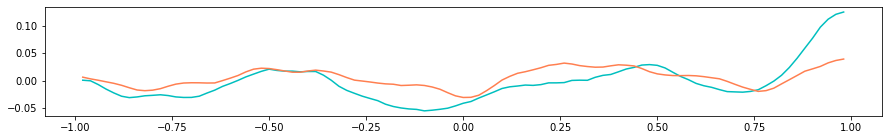

cell_roi_id: 1080744341 All data score 0.7016574585635359 5-fold av. score 0.6576576576576576


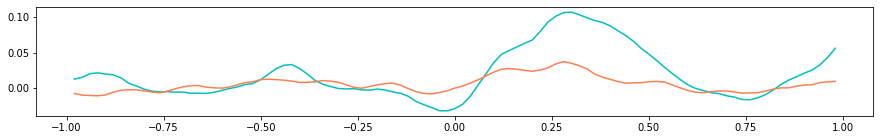

cell_roi_id: 1080744999 All data score 0.7292817679558011 5-fold av. score 0.6576576576576576


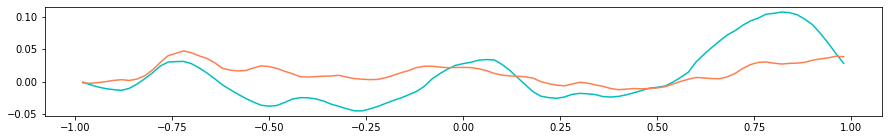

cell_roi_id: 1080739641 All data score 0.7016574585635359 5-fold av. score 0.6524024024024023


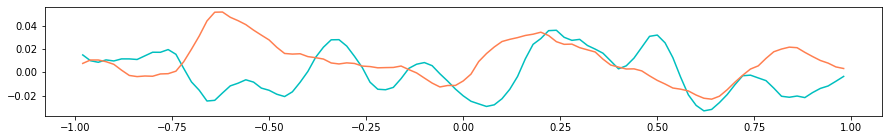

cell_roi_id: 1080744993 All data score 0.6961325966850829 5-fold av. score 0.651951951951952


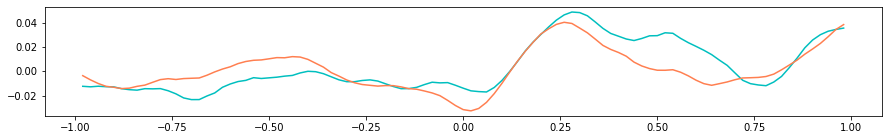

cell_roi_id: 1080743785 All data score 0.7182320441988951 5-fold av. score 0.6518018018018018


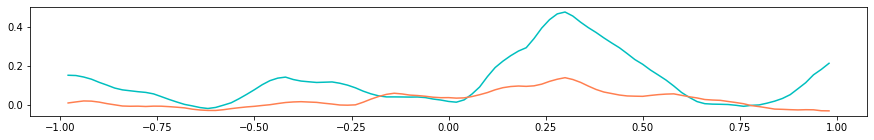

cell_roi_id: 1080738976 All data score 0.7182320441988951 5-fold av. score 0.6518018018018018


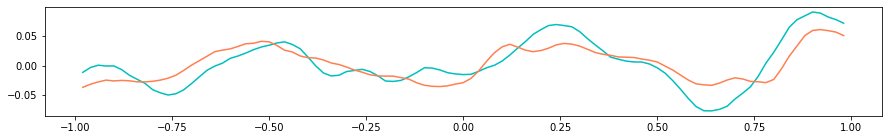

cell_roi_id: 1080744401 All data score 0.6685082872928176 5-fold av. score 0.6518018018018018


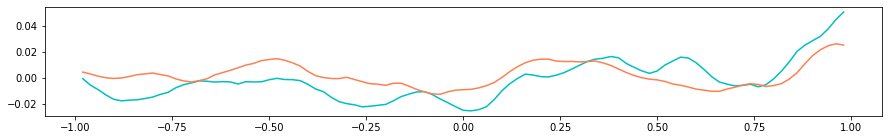

cell_roi_id: 1080742704 All data score 0.6906077348066298 5-fold av. score 0.6516516516516517


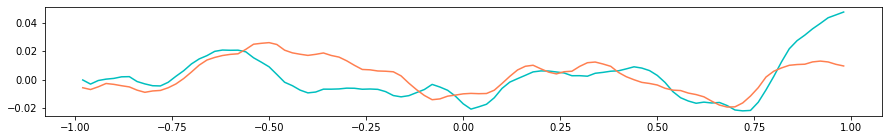

cell_roi_id: 1080743862 All data score 0.712707182320442 5-fold av. score 0.6468468468468468


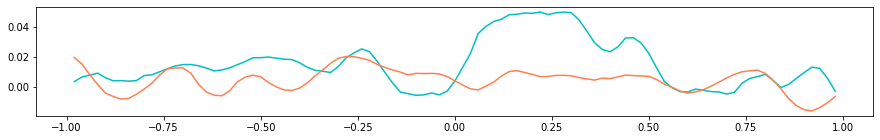

cell_roi_id: 1080743763 All data score 0.7071823204419889 5-fold av. score 0.6466966966966966


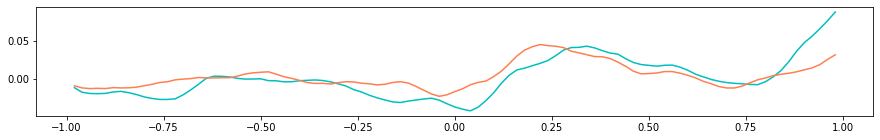

cell_roi_id: 1080743698 All data score 0.7458563535911602 5-fold av. score 0.6462462462462463


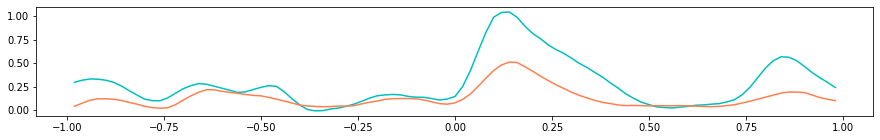

cell_roi_id: 1080744326 All data score 0.7513812154696132 5-fold av. score 0.6460960960960962


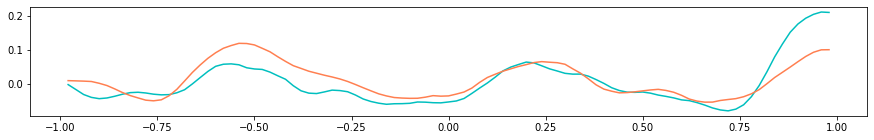

cell_roi_id: 1080739049 All data score 0.7403314917127072 5-fold av. score 0.6408408408408408


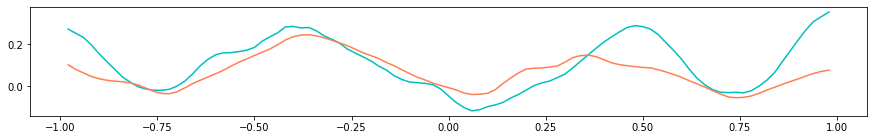

cell_roi_id: 1080738970 All data score 0.7348066298342542 5-fold av. score 0.6408408408408408


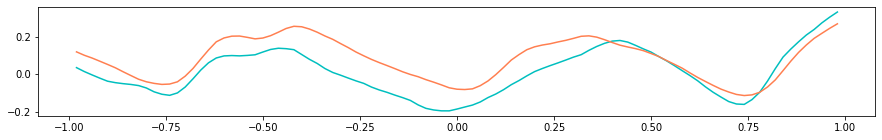

cell_roi_id: 1080742684 All data score 0.6850828729281768 5-fold av. score 0.6406906906906907


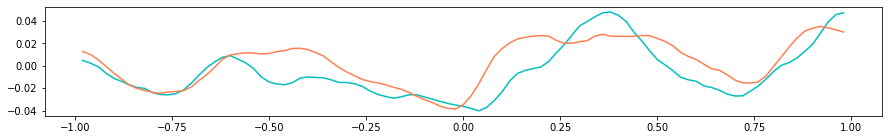

cell_roi_id: 1080742683 All data score 0.7071823204419889 5-fold av. score 0.6405405405405405


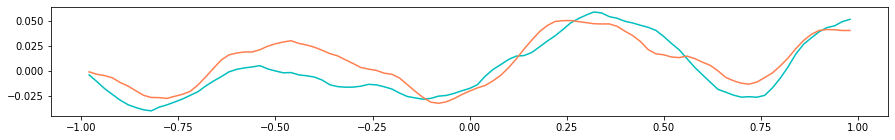

cell_roi_id: 1080745027 All data score 0.7292817679558011 5-fold av. score 0.6403903903903905


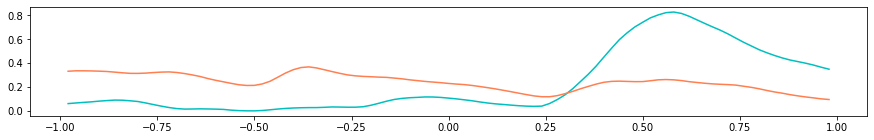

cell_roi_id: 1080743783 All data score 0.7292817679558011 5-fold av. score 0.636036036036036


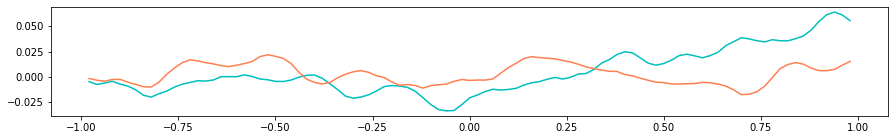

cell_roi_id: 1080744337 All data score 0.7016574585635359 5-fold av. score 0.6355855855855855


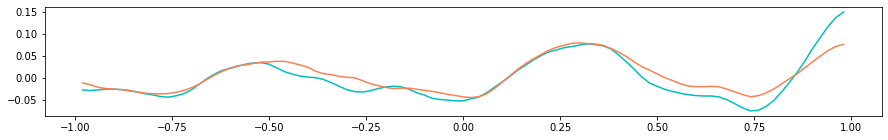

cell_roi_id: 1080743932 All data score 0.7071823204419889 5-fold av. score 0.6348348348348349


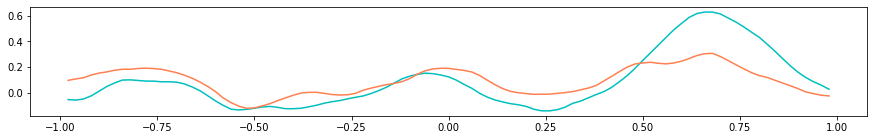

cell_roi_id: 1080743834 All data score 0.7237569060773481 5-fold av. score 0.6301801801801801


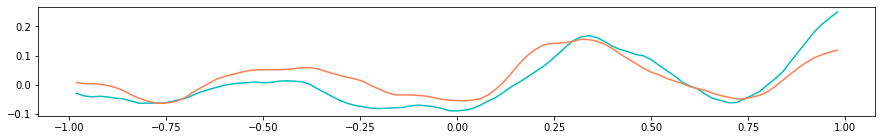

cell_roi_id: 1080742688 All data score 0.712707182320442 5-fold av. score 0.6294294294294294


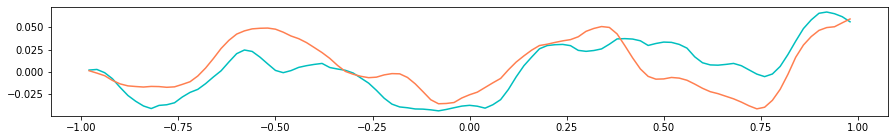

cell_roi_id: 1080745024 All data score 0.7182320441988951 5-fold av. score 0.6244744744744744


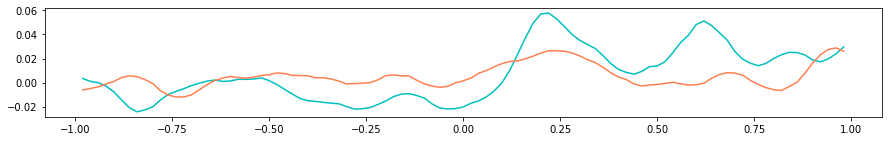

cell_roi_id: 1080739680 All data score 0.6574585635359116 5-fold av. score 0.6243243243243243


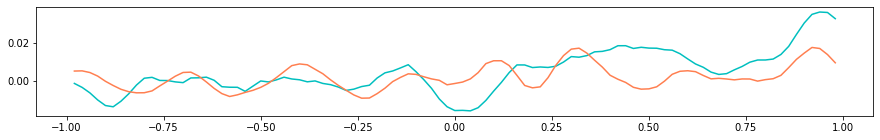

cell_roi_id: 1080744349 All data score 0.6795580110497238 5-fold av. score 0.6243243243243243


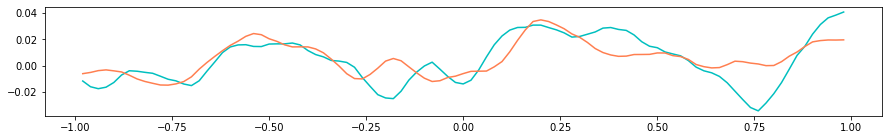

cell_roi_id: 1080744391 All data score 0.6685082872928176 5-fold av. score 0.6243243243243243


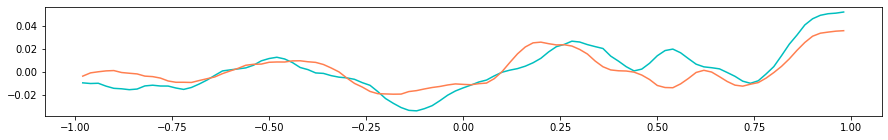

cell_roi_id: 1080739616 All data score 0.6795580110497238 5-fold av. score 0.6241741741741743


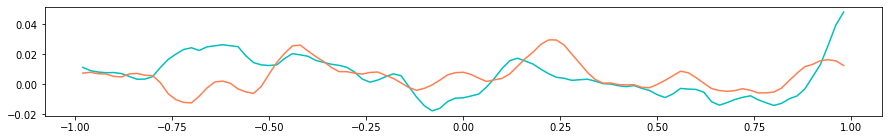

cell_roi_id: 1080743765 All data score 0.6574585635359116 5-fold av. score 0.6241741741741742


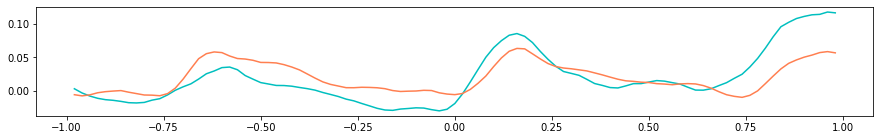

cell_roi_id: 1080738974 All data score 0.7845303867403315 5-fold av. score 0.6241741741741742


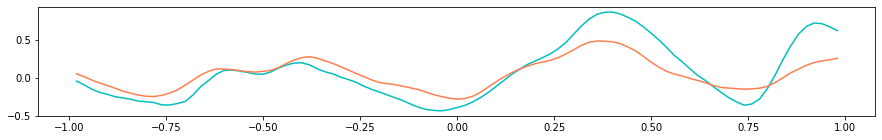

cell_roi_id: 1080743829 All data score 0.6906077348066298 5-fold av. score 0.6189189189189189


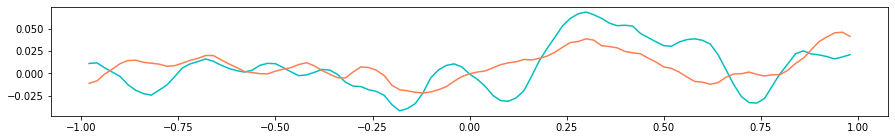

cell_roi_id: 1080743775 All data score 0.6519337016574586 5-fold av. score 0.6189189189189189


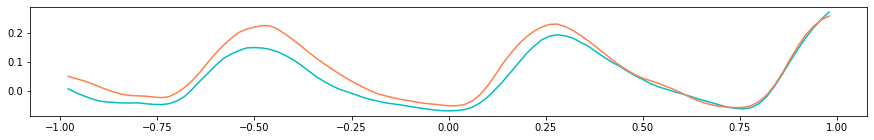

cell_roi_id: 1080744321 All data score 0.6961325966850829 5-fold av. score 0.6186186186186188


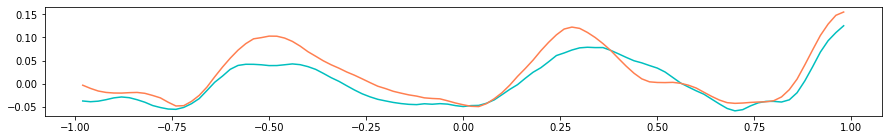

cell_roi_id: 1080743855 All data score 0.6850828729281768 5-fold av. score 0.6183183183183184


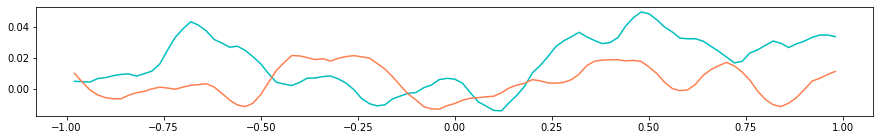

cell_roi_id: 1080739015 All data score 0.6961325966850829 5-fold av. score 0.6133633633633634


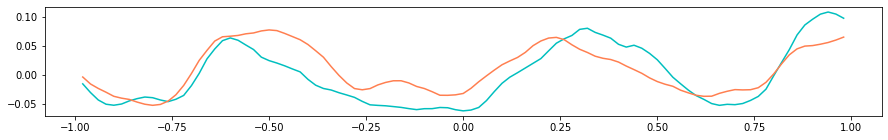

cell_roi_id: 1080743802 All data score 0.7071823204419889 5-fold av. score 0.6133633633633634


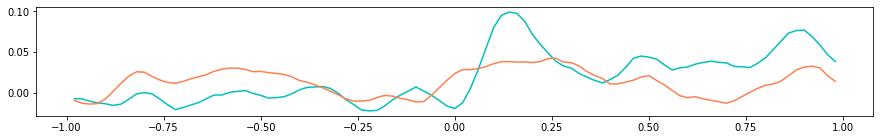

cell_roi_id: 1080745030 All data score 0.6850828729281768 5-fold av. score 0.6133633633633634


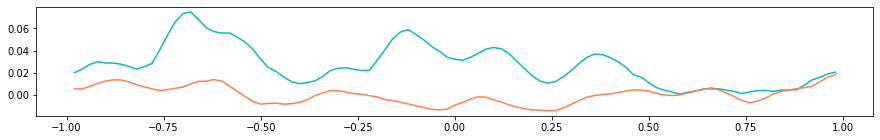

cell_roi_id: 1080742685 All data score 0.6906077348066298 5-fold av. score 0.6132132132132131


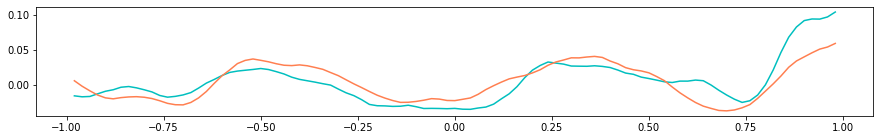

cell_roi_id: 1080743741 All data score 0.6519337016574586 5-fold av. score 0.613063063063063


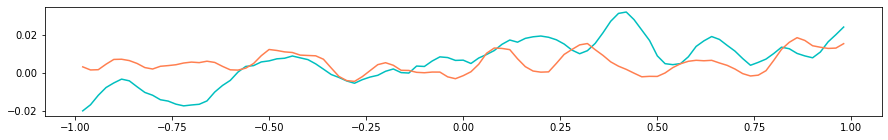

cell_roi_id: 1080742701 All data score 0.6850828729281768 5-fold av. score 0.6075075075075075


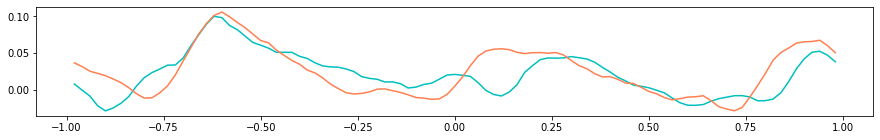

cell_roi_id: 1080745003 All data score 0.712707182320442 5-fold av. score 0.6027027027027027


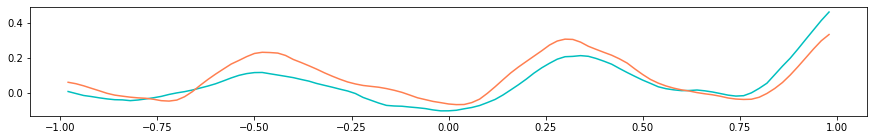

cell_roi_id: 1080744985 All data score 0.6740331491712708 5-fold av. score 0.6022522522522522


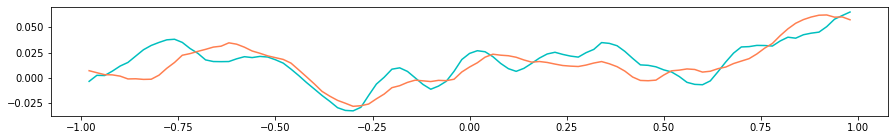

cell_roi_id: 1080743831 All data score 0.7348066298342542 5-fold av. score 0.601951951951952


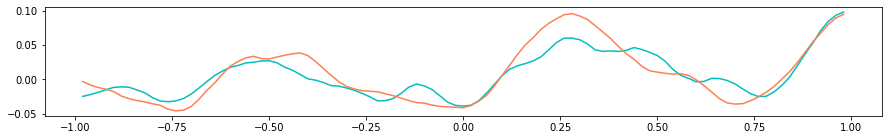

cell_roi_id: 1080744997 All data score 0.6740331491712708 5-fold av. score 0.5971471471471472


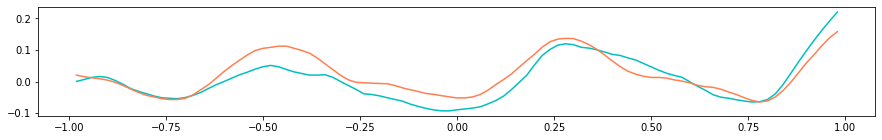

cell_roi_id: 1080743868 All data score 0.6795580110497238 5-fold av. score 0.5971471471471472


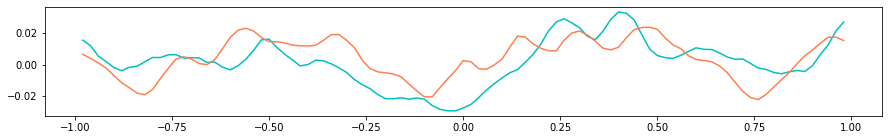

cell_roi_id: 1080739673 All data score 0.6574585635359116 5-fold av. score 0.5965465465465466


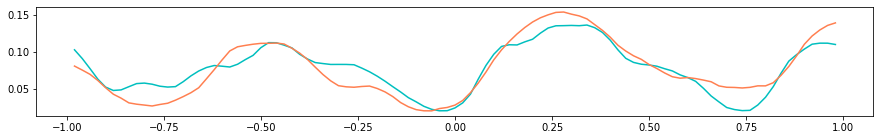

cell_roi_id: 1080745001 All data score 0.6906077348066298 5-fold av. score 0.5854354354354354


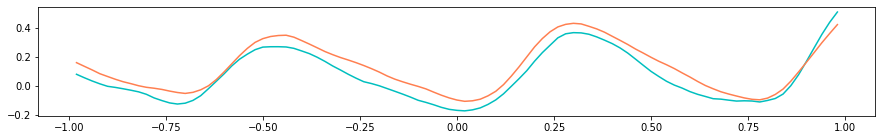

cell_roi_id: 1080743737 All data score 0.7071823204419889 5-fold av. score 0.5801801801801802


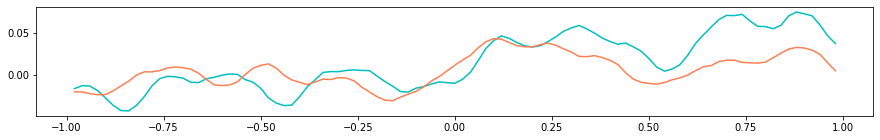

cell_roi_id: 1080742698 All data score 0.6464088397790055 5-fold av. score 0.5801801801801802


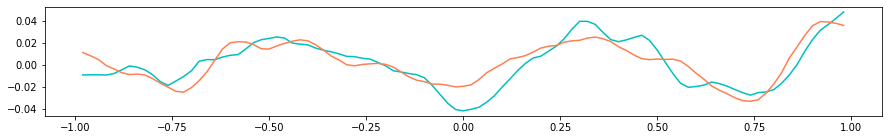

cell_roi_id: 1080743841 All data score 0.7348066298342542 5-fold av. score 0.5798798798798799


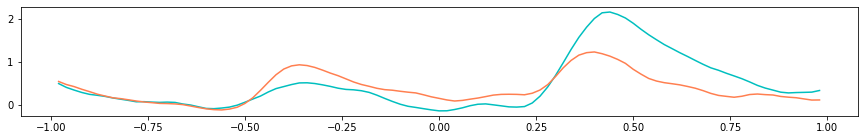

cell_roi_id: 1080744354 All data score 0.6629834254143646 5-fold av. score 0.574924924924925


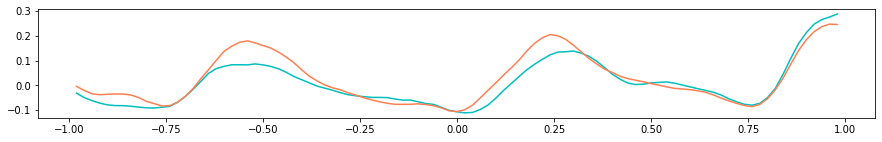

cell_roi_id: 1080743754 All data score 0.6408839779005525 5-fold av. score 0.5744744744744745


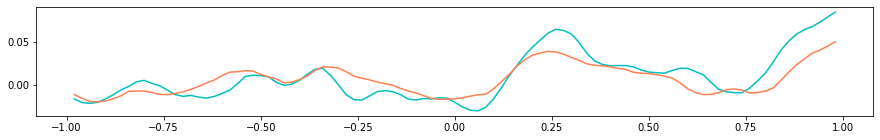

cell_roi_id: 1080742681 All data score 0.7513812154696132 5-fold av. score 0.563963963963964


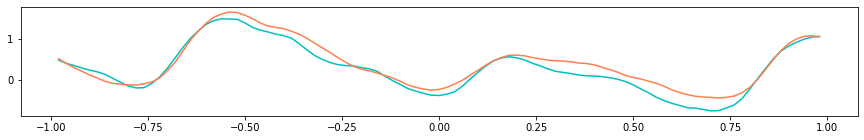

cell_roi_id: 1080745009 All data score 0.7624309392265194 5-fold av. score 0.5354354354354354


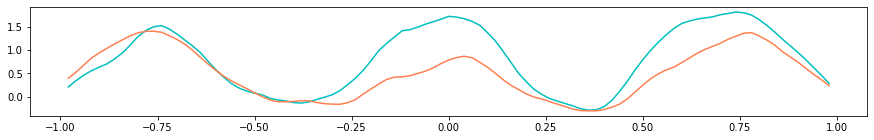

In [36]:
#good_cells = [1080738985, 1080738999]
for cell_roi_id in models_df.index:
  score = cells_lr_dictionary3[cell_roi_id][3]
  mean_score_cv = cells_lr_dictionary3[cell_roi_id][4]
  print("cell_roi_id:", cell_roi_id, "All data score", score, "5-fold av. score", mean_score_cv)
  plt.figure(figsize=(15,2))
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'hit') & (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='c')
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'miss')& (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='coral')
  plt.show()

# Responsive cells :)

In [76]:
#dictionary roi to specimen
cell_roi_to_specimen = {}
for cell_roi_id in cells_roi_ids:
  cell_roi_to_specimen[cell_roi_id] = np.unique(np.array(my_cells[my_cells.cell_roi_id == cell_roi_id]['cell_specimen_id']))

cell_specimen_to_roi = {}
for cell_specimen_id in np.unique(my_cells['cell_specimen_id']):
  cell_specimen_to_roi[cell_specimen_id] = np.unique(np.array(my_cells[my_cells.cell_specimen_id == cell_specimen_id]['cell_roi_id']))

In [78]:
good_ones_lr_roi_ids = list(models_df[models_df.mean_score_cv > 0.7].index)
good_ones_lr_specimen_ids = np.zeros_like(good_ones_lr_roi_ids)
for i, cell_roi_id in enumerate(good_ones_lr_roi_ids):
  good_ones_lr_specimen_ids[i] = cell_roi_to_specimen[cell_roi_id]


good_ones_corr_specimen_ids = np.array([1086615201, 1086615620, 1086615837, 1086616206, 1086616398,
            1086617208, 1086617362, 1086617474, 1086617875, 1086618186,
            1086618253, 1086618338, 1086618511, 1086618575, 1086618656,
 1086619132, 1086619247, 1086619317])
good_ones_corr_roi_ids = np.zeros_like(good_ones_corr_specimen_ids)
for i, cell_specimen_id in enumerate(good_ones_corr_specimen_ids):
  good_ones_corr_roi_ids[i] = cell_specimen_to_roi[cell_specimen_id]

print(np.sort(good_ones_corr_specimen_ids))
print(np.sort(good_ones_lr_specimen_ids))
print("------------------")
print(np.sort(good_ones_corr_roi_ids))
print(np.sort(good_ones_lr_roi_ids))

[1086615201 1086615620 1086615837 1086616206 1086616398 1086617208
 1086617362 1086617474 1086617875 1086618186 1086618253 1086618338
 1086618511 1086618575 1086618656 1086619132 1086619247 1086619317]
[1086607195 1086608577 1086608948 1086609454 1086610475 1086611645
 1086613265 1086615837 1086617362 1086617875 1086618186 1086618253
 1086618338 1086619804 1086621290 1086621818]
------------------
[1080738970 1080738971 1080738974 1080738985 1080738999 1080739002
 1080739004 1080739007 1080739015 1080739019 1080739033 1080739049
 1080743785 1080743794 1080743799 1080743817 1080743847 1080744993]
[1080738971 1080738985 1080738999 1080739002 1080739004 1080739009
 1080739702 1080742677 1080743712 1080743723 1080743762 1080743799
 1080743904 1080743912 1080744315 1080745021]


In [93]:
#check if any neurons identified with lr are identified by correlation
repeats = np.zeros_like(good_ones_lr_specimen_ids)
for i, cell_specimen_id in enumerate(good_ones_lr_specimen_ids):
  repeats[i] = np.any(good_ones_corr_specimen_ids == cell_specimen_id)

good_ones_both_specimen_ids = good_ones_lr_specimen_ids[repeats == 1]
good_ones_both_roi_ids = np.zeros_like(good_ones_both_specimen_ids)
for i, cell_specimen_id in enumerate(good_ones_both_specimen_ids):
  good_ones_both_roi_ids[i] = cell_specimen_to_roi[cell_specimen_id]

# Plot responsive cells

## About the cells

In [54]:
neural_data  = session_dictionary[ophys_session_id][1]

In [57]:
good_cells_dict = {} #(specimen_id as a key!!!)
for cell_specimen_id in good_ones_both_specimen_ids:
  good_cells_dict[cell_specimen_id] = {}
  good_cells_dict[cell_specimen_id]['imaging_depth'] = np.unique(np.array(my_cells[my_cells.cell_specimen_id == cell_specimen_id]['imaging_depth']))
  good_cells_dict[cell_specimen_id]['targeted_structure'] = np.unique(np.array(neural_data[neural_data.cell_specimen_id == cell_specimen_id]['targeted_structure']))

good_cells_df = pd.DataFrame.from_dict(good_cells_dict, orient = 'columns')
good_cells_df

1086618186 1086617875 1086617362 1086618253 1086618338  \
imaging_depth           [225]      [225]      [225]      [225]      [225]   
targeted_structure     [VISl]     [VISl]     [VISl]     [VISl]     [VISl]   

                   1086615837  
imaging_depth           [150]  
targeted_structure     [VISp]

### How many cells from VISl do we have?

In [80]:
all_str_depth_specimen_id = np.unique(neural_data[(neural_data.imaging_depth == 225) & (neural_data.targeted_structure == 'VISl')]['cell_specimen_id'])
print('number of cells on 255 and VISl', len(all_str_depth_specimen_id))

repeats = np.zeros_like(all_str_depth)
for i, cell_specimen_id in enumerate(all_str_depth):
  repeats[i] = np.any(good_ones_lr_specimen_ids == cell_specimen_id)
print('number of cells on 255 and VISl marked as responsive by LR', np.sum(repeats))

repeats = np.zeros_like(all_str_depth)
for i, cell_specimen_id in enumerate(all_str_depth):
  repeats[i] = np.any(good_ones_lr_specimen_ids == cell_specimen_id)
print('number of cells on 255 and VISl marked as responsive by LR', np.sum(repeats))

repeats = np.zeros_like(all_str_depth)
for i, cell_specimen_id in enumerate(all_str_depth):
  repeats[i] = np.any(good_ones_corr_specimen_ids == cell_specimen_id)
print('number of cells on 255 and VISl marked as responsive by correlation', np.sum(repeats))


number of cells on 255 and VISl 14
number of cells on 255 and VISl marked as responsive by LR 6
number of cells on 255 and VISl marked as responsive by LR 6
number of cells on 255 and VISl marked as responsive by correlation 12


In [68]:
all_str_depth_roi_id = np.unique(neural_data[(neural_data.imaging_depth == 225) & (neural_data.targeted_structure == 'VISl')]['cell_roi_id'])

len(all_str_depth_roi_id)


14

In [69]:
models_df.head()

trial_result  \
1080738999  event_number  hit_miss
0             hit      ...   
1080738985  event_number  hit_miss
0             hit      ...   
1080743723  event_number  hit_miss
0             hit      ...   
1080742677  event_number  hit_miss
0             hit      ...   
1080739009  event_number  hit_miss
0             hit      ...   

                                                   timeseries  \
1080738999  time                      -1.00     -0.98     ...   
1080738985  time                      -1.00     -0.98     ...   
1080743723  time                      -1.00     -0.98     ...   
1080742677  time                      -1.00     -0.98     ...   
1080739009  time                      -1.00     -0.98     ...   

                                                      log_reg  score_single  \
1080738999  LogisticRegression(C=1.0, class_weight=None, d...      0.900552   
1080738985  LogisticRegression(C=1.0, class_weight=None, d...      0.856354   
1080743723  LogisticRegression(C=1.0, class_weight=None, d...      0.839779   
1080742677  LogisticRegression(C=1.0, class_weight=None, d...      0.823204   
1080739009  LogisticRegression(C=1.0, class_weight=None, d...      0.767956   

            mean_score_cv  
1080738999       0.872372  
1080738985       0.817417  
1080743723       0.806607  
1080742677       0.784835  
1080739009       0.756607

## Look at the selected cells

cell_roi_id: 1080738999 All data score 0.9005524861878453 5-fold av. score 0.8723723723723724


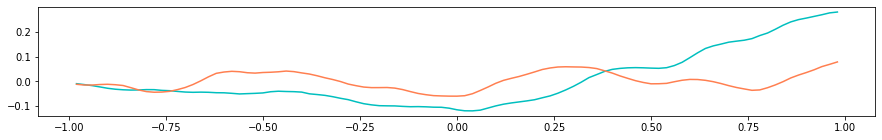

cell_roi_id: 1080738985 All data score 0.856353591160221 5-fold av. score 0.8174174174174175


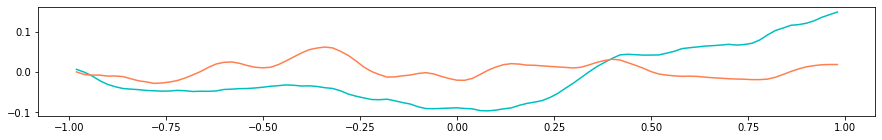

cell_roi_id: 1080743723 All data score 0.8397790055248618 5-fold av. score 0.8066066066066065


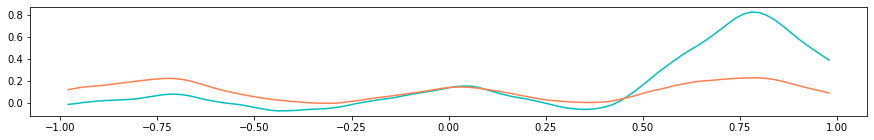

cell_roi_id: 1080742677 All data score 0.8232044198895028 5-fold av. score 0.7848348348348348


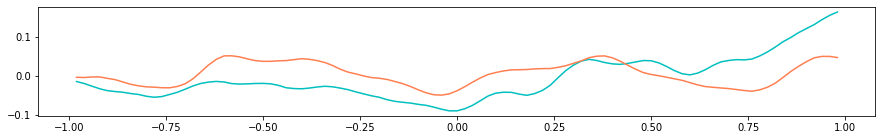

cell_roi_id: 1080739009 All data score 0.7679558011049724 5-fold av. score 0.7566066066066066


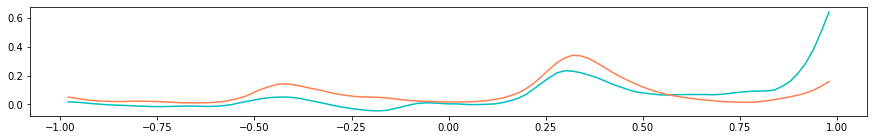

cell_roi_id: 1080739702 All data score 0.7955801104972375 5-fold av. score 0.7512012012012013


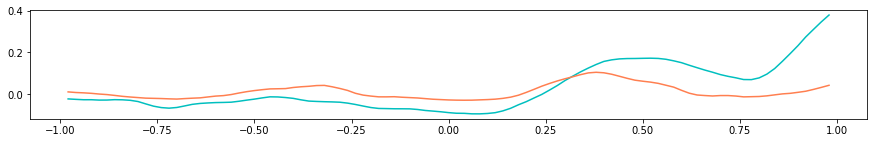

cell_roi_id: 1080744315 All data score 0.7845303867403315 5-fold av. score 0.7454954954954955


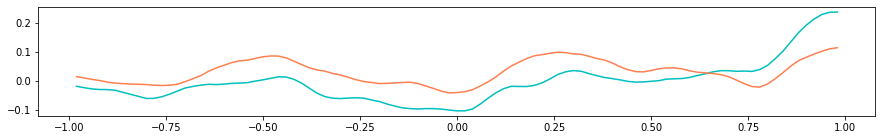

cell_roi_id: 1080738971 All data score 0.7734806629834254 5-fold av. score 0.7346846846846846


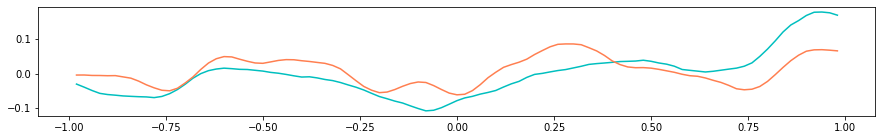

cell_roi_id: 1080739002 All data score 0.8011049723756906 5-fold av. score 0.7297297297297296


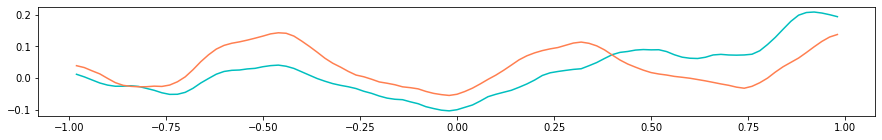

cell_roi_id: 1080743912 All data score 0.7734806629834254 5-fold av. score 0.7295795795795795


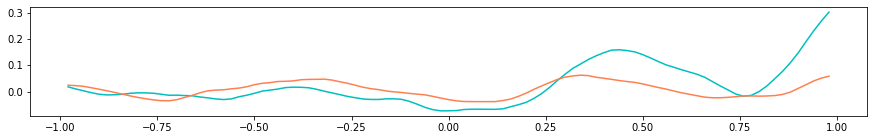

cell_roi_id: 1080743712 All data score 0.7569060773480663 5-fold av. score 0.7243243243243244


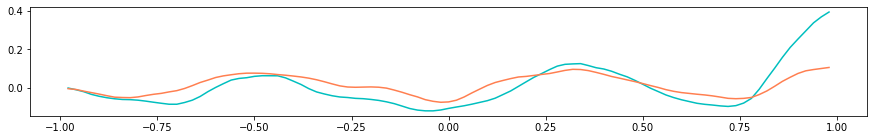

cell_roi_id: 1080743762 All data score 0.7845303867403315 5-fold av. score 0.7237237237237237


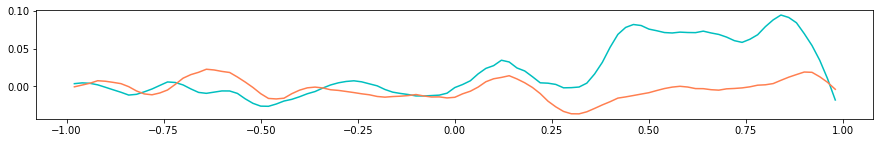

cell_roi_id: 1080743904 All data score 0.7569060773480663 5-fold av. score 0.7129129129129129


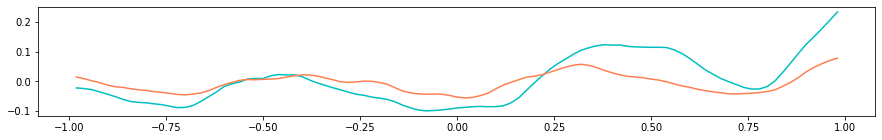

cell_roi_id: 1080745021 All data score 0.7458563535911602 5-fold av. score 0.7124624624624625


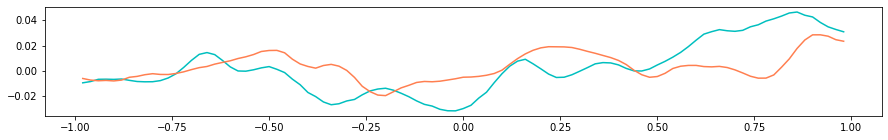

cell_roi_id: 1080739004 All data score 0.7900552486187845 5-fold av. score 0.7066066066066066


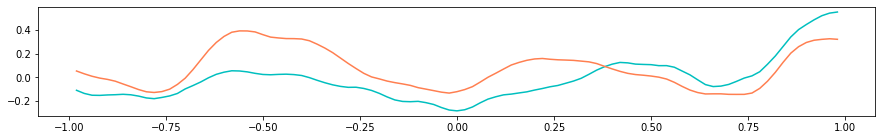

cell_roi_id: 1080743799 All data score 0.7513812154696132 5-fold av. score 0.7013513513513513


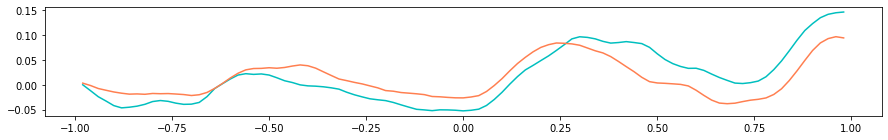

In [75]:
for cell_roi_id in models_df[models_df.index.isin(good_ones_both)].index:
  score = cells_lr_dictionary3[cell_roi_id][3]
  mean_score_cv = cells_lr_dictionary3[cell_roi_id][4]
  print("cell_roi_id:", cell_roi_id, "All data score", score, "5-fold av. score", mean_score_cv)
  plt.figure(figsize=(15,2))
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'hit') & (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='c')
  plt.plot('time', 
              'dff', 
              data = my_cells_av[(my_cells_av.cell_roi_id == cell_roi_id) & (my_cells_av.hit_miss == 'miss')& (my_cells_av.time > bfr) & (my_cells_av.time < aftr)],
              color='coral')
  plt.show()

# LR model for cells from Sl depth 225

In [83]:
my_cells_pivot.head()

time                                   -3.0     -2.98     -2.96     -2.94  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit      -0.518886 -0.477384 -0.156231  0.164921   
                         miss     -0.219072 -0.219072 -0.219072 -0.204036   
            1            hit       0.300976  0.300976  0.306854  0.318229   
                         miss      0.139042  0.139042  0.150526  0.175533   
            2            hit       0.553156  0.553156  0.553156  0.611350   

time                                  -2.92      -2.9     -2.88     -2.86  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.486074  0.807226  0.918243  0.790126   
                         miss     -0.108099 -0.012161  0.083776  0.179713   
            1            hit       0.329604  0.340980  0.352355  0.300047   
                         miss      0.200540  0.225547  0.250553  0.369271   
            2            hit       0.765209  0.919068  1.072926  1.226785   

time                                  -2.84     -2.82      -2.8     -2.78  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.662009  0.533892  0.405775  0.398557   
                         miss      0.187962  0.106832  0.025703 -0.055427   
            1            hit       0.236959  0.173871  0.110783  0.054258   
                         miss      0.511750  0.654229  0.796708  0.929685   
            2            hit       1.284542  1.304317  1.324091  1.343866   

time                                  -2.76     -2.74  -2.7199999999999998  \
cell_roi_id event_number hit_miss                                            
1080738970  0            hit       0.420490  0.442424             0.464357   
                         miss     -0.136557 -0.001696             0.176239   
            1            hit       0.025046 -0.004166            -0.033378   
                         miss      1.002151  1.074618             1.147085   
            2            hit       1.353645  1.192436             1.031227   

time                                   -2.7     -2.68     -2.66     -2.64  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.480579  0.462915  0.445251  0.427586   
                         miss      0.354175  0.532111  0.665921  0.586907   
            1            hit      -0.062590 -0.129170 -0.228593 -0.328016   
                         miss      1.219552  1.235435  1.188585  1.141734   
            2            hit       0.870018  0.708809  0.574063  0.480066   

time                                  -2.62      -2.6     -2.58     -2.56  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.409922  0.389293  0.365486  0.341679   
                         miss      0.507892  0.428878  0.349863  0.371015   
            1            hit      -0.427438 -0.526861 -0.537273 -0.534470   
                         miss      1.094884  1.048034  0.886260  0.698006   
            2            hit       0.386068  0.292071  0.198073  0.162296   

time                                  -2.54     -2.52      -2.5     -2.48  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit       0.317873  0.294066 -0.000127 -0.353180   
                         miss      0.488318  0.605621  0.722924  0.840227   
            1            hit      -0.531667 -0.528864 -0.508693 -0.422878   
                         miss      0.509751  0.321497  0.173777  0.254447   
            2            hit       0.147810  0.133324  0.118838  0.100353   

time                                  -2.46     -2.44     -2.42      -2.4  \
cell_roi_id event_number hit_miss                                           
1080738970  0            hit      -0.706233 -1.059286 -1.32

In [97]:
model_sl255 = LogisticRegression(penalty='l2', max_iter=500)
cells_choice = all_str_depth_roi_id

bfr = -1
aftr = 1
loc_minus = my_cells_pivot.columns.get_loc(bfr)
loc_plus = my_cells_pivot.columns.get_loc(aftr)

trial_result = my_cells_pivot[my_cells_pivot.index.get_level_values('cell_roi_id').isin(cells_choice)].hit
timeseries = my_cells_pivot[my_cells_pivot.index.get_level_values('cell_roi_id').isin(cells_choice)].iloc[:,loc_minus:loc_plus+1]

model_sl255.fit(timeseries, trial_result)

accuracy = np.average(trial_result == model_sl255.predict(timeseries))

cv_scores = cross_val_score(LogisticRegression(penalty='l2', max_iter=500), timeseries, trial_result, cv=5)

print(model_sl255.coef_)
print(accuracy)
print(cv_scores)

[[ 0.23393753  0.02104743  0.05277531  0.11961899 -0.32721327 -0.22614353
  -0.22259403  0.3161973  -0.00497666  0.30099598  0.19811579 -0.1853291
  -0.45789204  0.09938951  0.12039435 -0.06392672 -0.16873017  0.38268887
  -0.16661947 -0.75566008  0.45867144  0.12981412 -0.34194166  0.26038099
  -0.12491818 -0.56580313  0.34497605  0.4576858  -0.42345921  0.22287626
  -0.0912994  -0.43627295  0.02057994  0.36596606 -0.23828119 -0.47829975
  -0.03431705  0.25292162 -0.01127609  0.29374028  0.19977116 -0.43303626
  -0.59425118  0.12099332  0.22209797 -0.10422654 -0.35216711 -0.06867519
  -0.27151379  0.19870957  0.42513302  0.05601679  0.21206067 -0.44350034
  -0.45014245  0.12953785  0.05740241 -0.28023923 -0.09723841  0.07131227
  -0.79526662 -0.02777596  0.06528051 -0.58443378  0.18666281  0.49255969
  -0.49363447 -0.24858243 -0.16782556  0.16778266  0.00246317  0.01952257
   0.46104978 -0.29031521 -0.53123259  0.56210372  0.41495754  0.14624119
  -0.01147976  0.04965803  0.23753463 -

# LR model for cells selected with both criteria

In [92]:
good_ones_both_roi_ids

array([0, 0, 0, 0, 0, 0])

In [102]:
model_both = LogisticRegression(penalty='l2', max_iter=500)
cells_choice = good_ones_both_roi_ids

bfr = -1
aftr = 1
loc_minus = my_cells_pivot.columns.get_loc(bfr)
loc_plus = my_cells_pivot.columns.get_loc(aftr)
time_array = my_cells_pivot.columns[loc_minus:(loc_plus+1)]

trial_result = my_cells_pivot[my_cells_pivot.index.get_level_values('cell_roi_id').isin(cells_choice)].hit
timeseries = my_cells_pivot[my_cells_pivot.index.get_level_values('cell_roi_id').isin(cells_choice)].iloc[:,loc_minus:loc_plus+1]

model_both.fit(timeseries, trial_result)

accuracy = np.average(trial_result == model_both.predict(timeseries))

cv_scores = cross_val_score(LogisticRegression(penalty='l2', max_iter=500), timeseries, trial_result, cv=5)

In [113]:
selected_cells_av = my_cells[my_cells.cell_roi_id.isin(cells_choice)].groupby(['hit_miss', 'time'], as_index=False).mean()
selected_cells_av = selected_cells_av[(selected_cells_av.time >= bfr) & (selected_cells_av.time <= aftr)]

0.7808471454880295
[0.74770642 0.85253456 0.78341014 0.73271889 0.69124424]


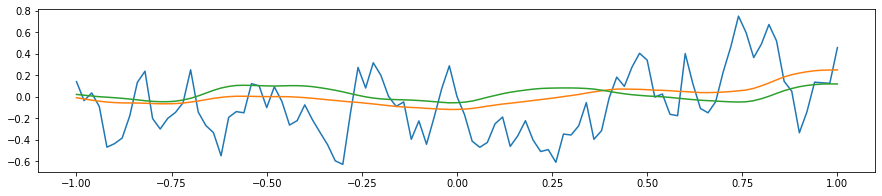

In [116]:
#print(model_both.coef_)
print(accuracy)
print(cv_scores)

plt.figure(figsize=(15,3))
plt.plot(time_array, model_both.coef_.T)
plt.plot('time', 'dff', data=selected_cells_av[selected_cells_av.hit_miss == 'hit'])
plt.plot('time', 'dff', data=selected_cells_av[selected_cells_av.hit_miss == 'miss'])
plt.show()
